# Toplevel Notebook for Stability Tuning

### Preparation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors
import numpy as np
import seaborn as sns
import stabtune_utils as stabtune_utils
import stabtune_plotter as stabtune_plotter
import os
import sys

sys.path.append('../../')
import config
%load_ext autoreload
%autoreload 2

### Action Required: Define the input (tuning dataframe) location

In [2]:
input_dir = '../../' # input directory for tuning dataframe
output_dir = 'C:\\Files\\UM\\ND\\github\\big_nhp_dataset_code\\outputs'
selected_channels = [0,30,60,90] # selected channels for displaying in polar plot

In [3]:
# load data
tuning_df = stabtune_utils.load_tuning_data(input_dir, overwrite=False)
tuning_df['date'] = pd.to_datetime(tuning_df['date'])
# testing function: ../../../../SFN/preprocessing_092024_no7822nofalcon
# testing function: ../../../../SFN/only_good_days

In [4]:
# testing: figuring out what is max and min of magnitude to bound the plot, delete later
max_magnitude = tuning_df['magnitude'].quantile(0.99)
min_magnitude = tuning_df['magnitude'].quantile(0.01)
# max_magnitude = tuning_df['magnitude'].max()
# min_magnitude = tuning_df['magnitude'].min()
print(f"0.99 Quantile (Max Magnitude): {max_magnitude}")
print(f"0.01 Quantile (Min Magnitude): {min_magnitude}")

0.99 Quantile (Max Magnitude): 0.055248681130602655
0.01 Quantile (Min Magnitude): 0.000944576769759674


## WIP Plots, will be moved to a general plotter after review and modification

### Variance across channels over time

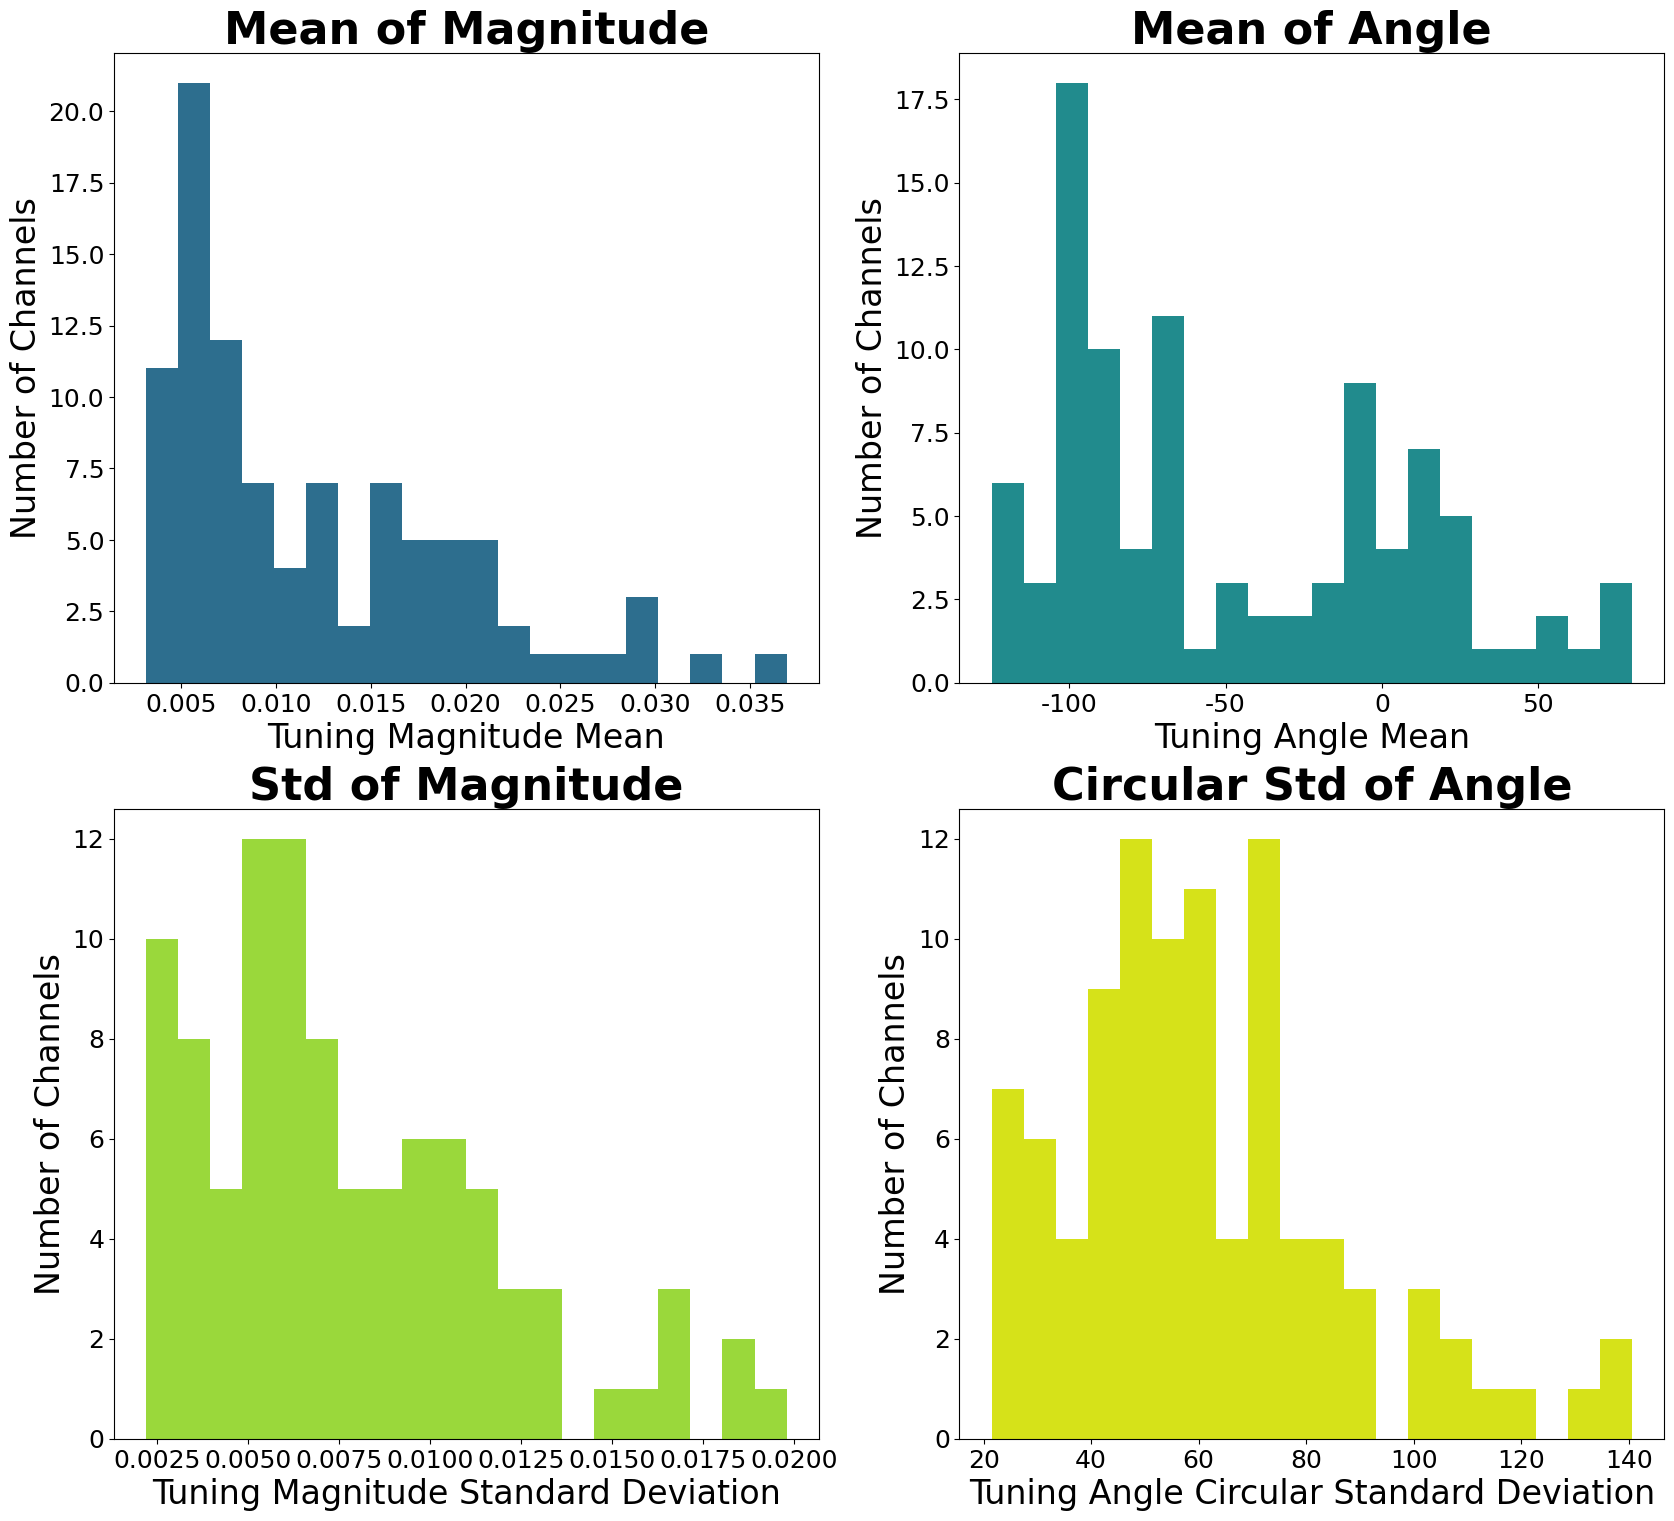

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(20, 18))
colours = ['#2D6E8E', '#218B8D', '#9AD83B', '#D6E219']
stabtune_plotter.plot_tuning_variance_histogram(ax[0,0], tuning_df, bins = 20,type = 'magnitude', metric = 'mean', colour = colours[0])
stabtune_plotter.plot_tuning_variance_histogram(ax[0,1], tuning_df, bins = 20,type = 'angle', metric = 'mean', colour = colours[1])
stabtune_plotter.plot_tuning_variance_histogram(ax[1,0], tuning_df, bins = 20,type = 'magnitude', metric = 'std', colour = colours[2])
stabtune_plotter.plot_tuning_variance_histogram(ax[1,1], tuning_df, bins = 20,type = 'angle', metric = 'circstd', colour = colours[3])

### Daily Tuning Spatial Heatmap

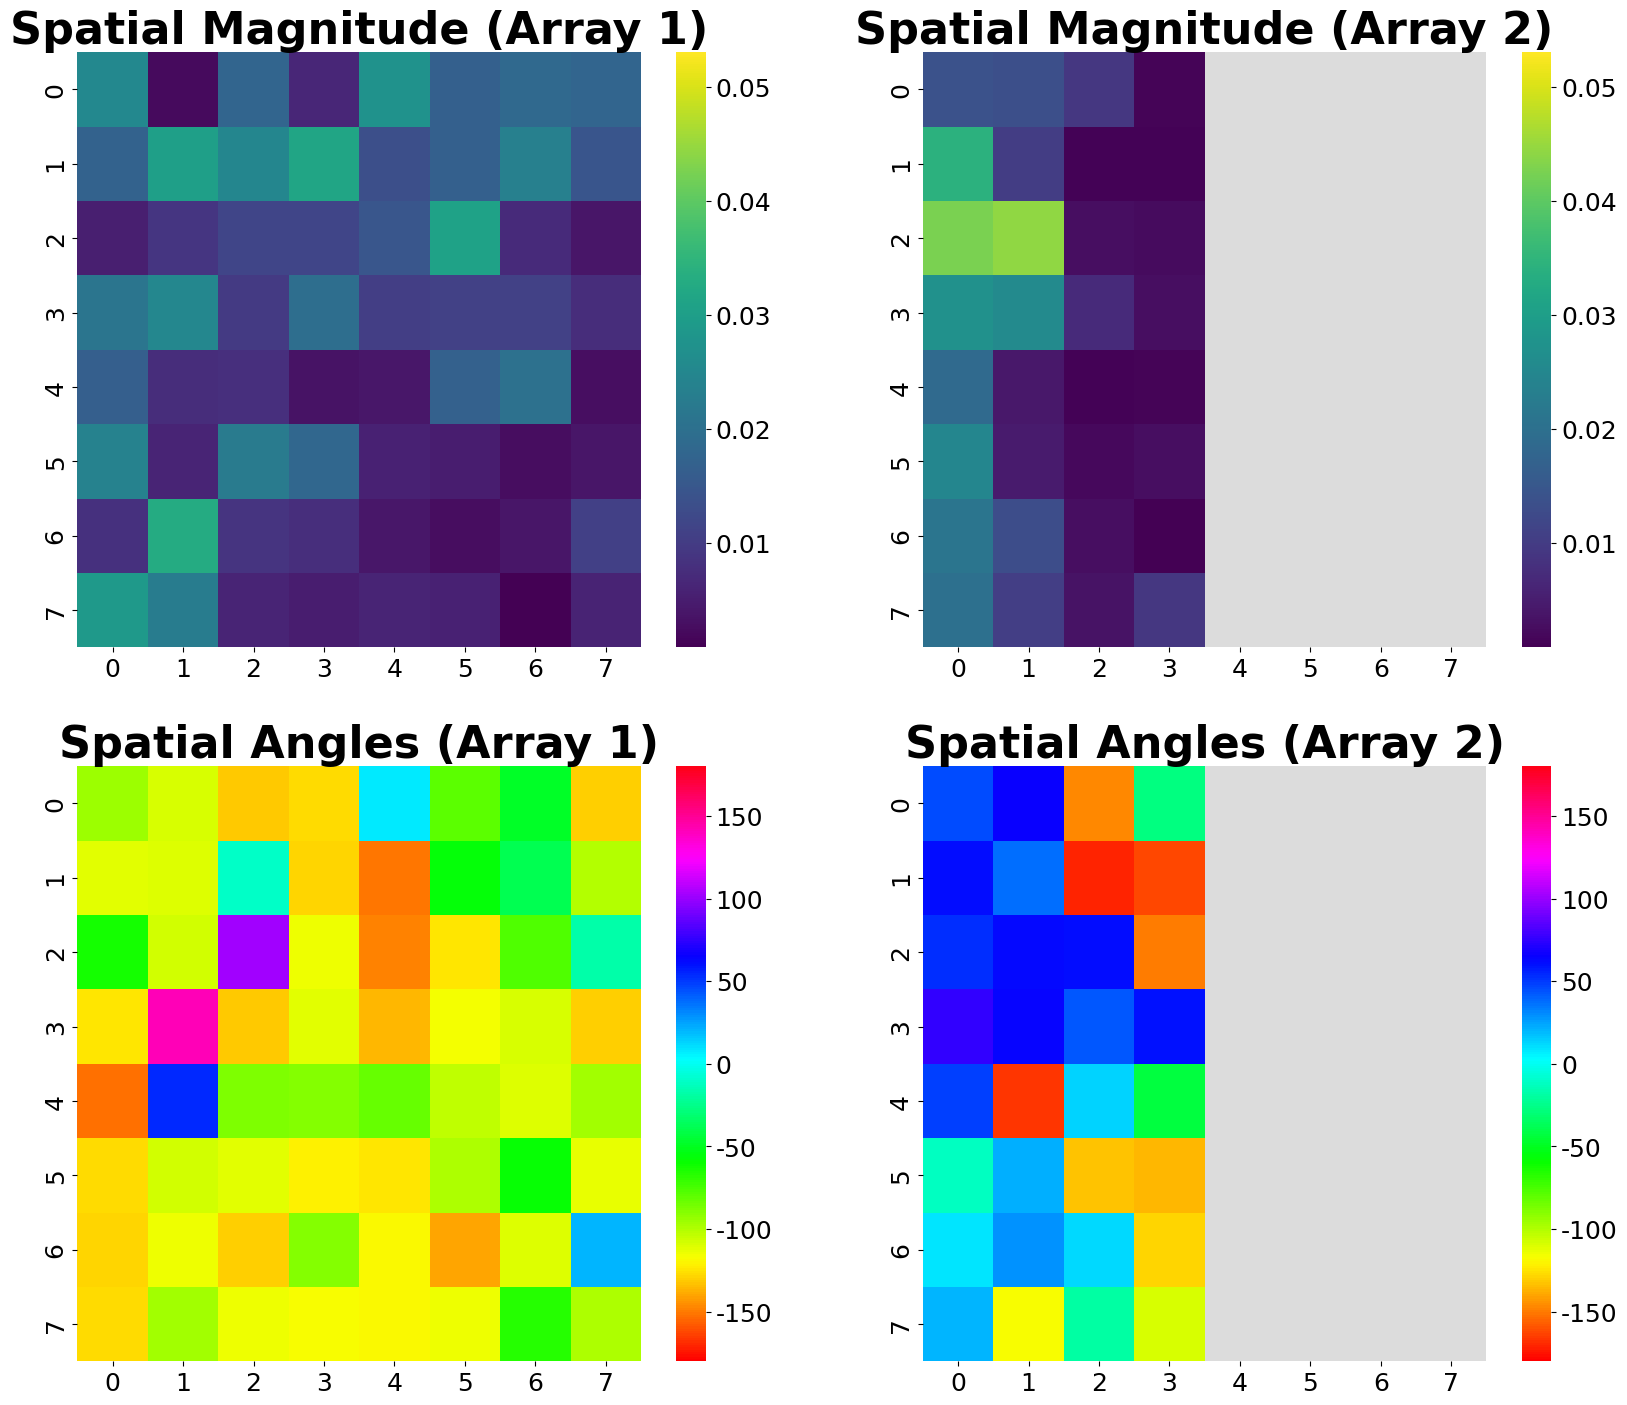

<Figure size 640x480 with 0 Axes>

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(20, 17))
selected_date = '2020-01-27'
stabtune_plotter.plot_daily_spatial_tuning(ax,tuning_df,selected_date,os.path.join('channel_spatial_mapping.csv'))
plt.show()
plt.savefig(os.path.join(output_dir, f'spatial_tuning_{selected_date}.pdf'))
plt.show()


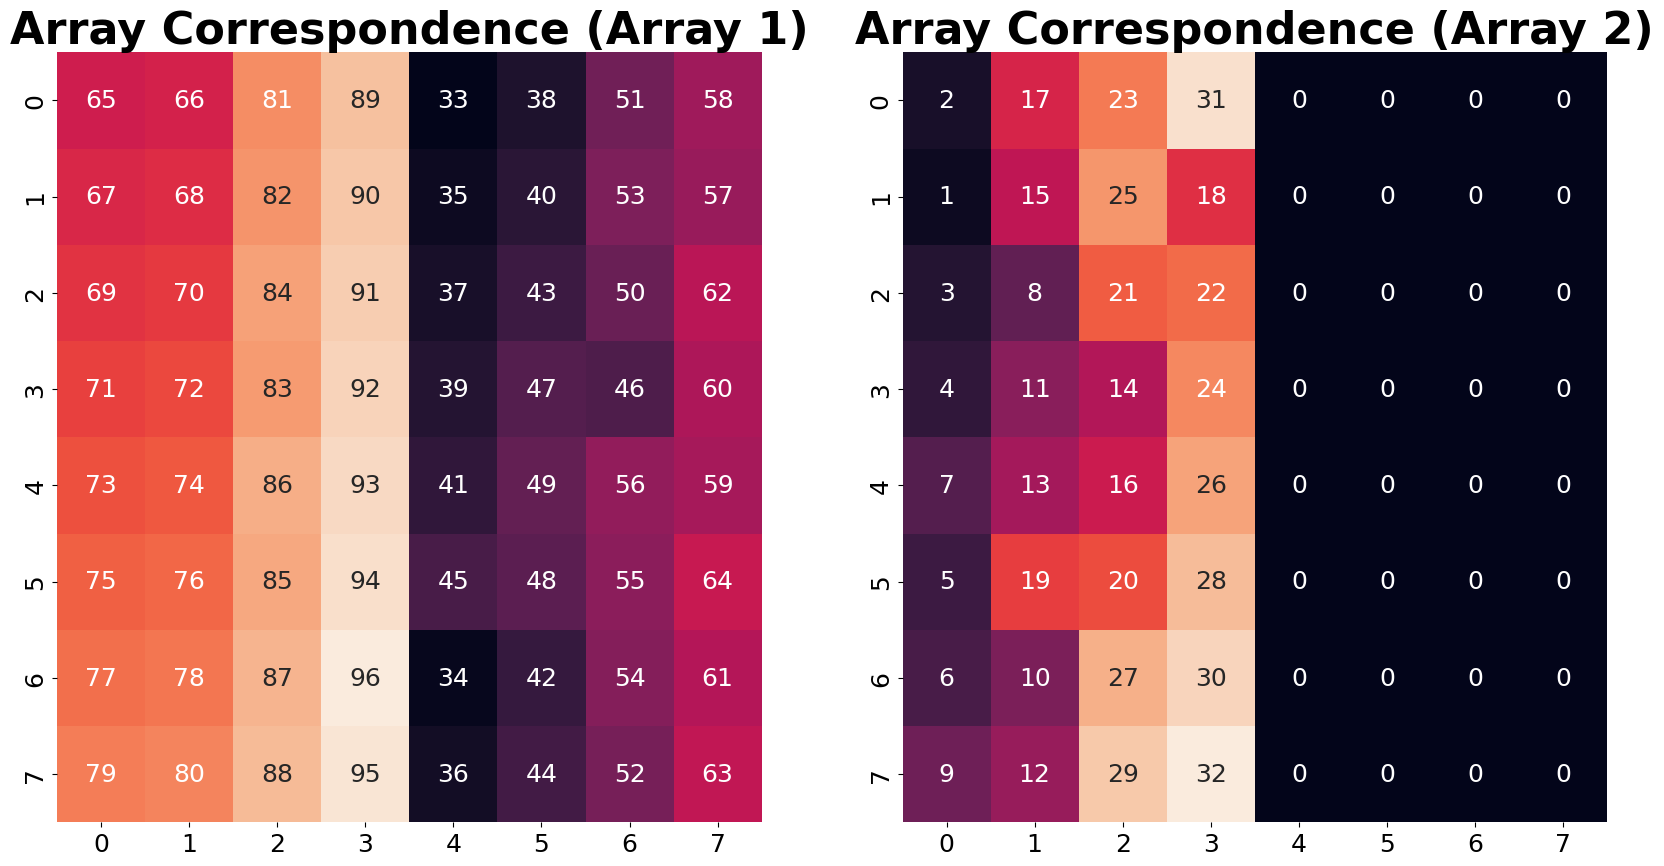

In [7]:
# For sanity check, plot the correspondence between channels and mapping
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
stabtune_plotter.plot_daily_spatial_tuning(ax,tuning_df,'2020-01-27',os.path.join('channel_spatial_mapping.csv'), correspondence= True)

plt.savefig(os.path.join(output_dir, 'array_correspondence.pdf'))
plt.show()


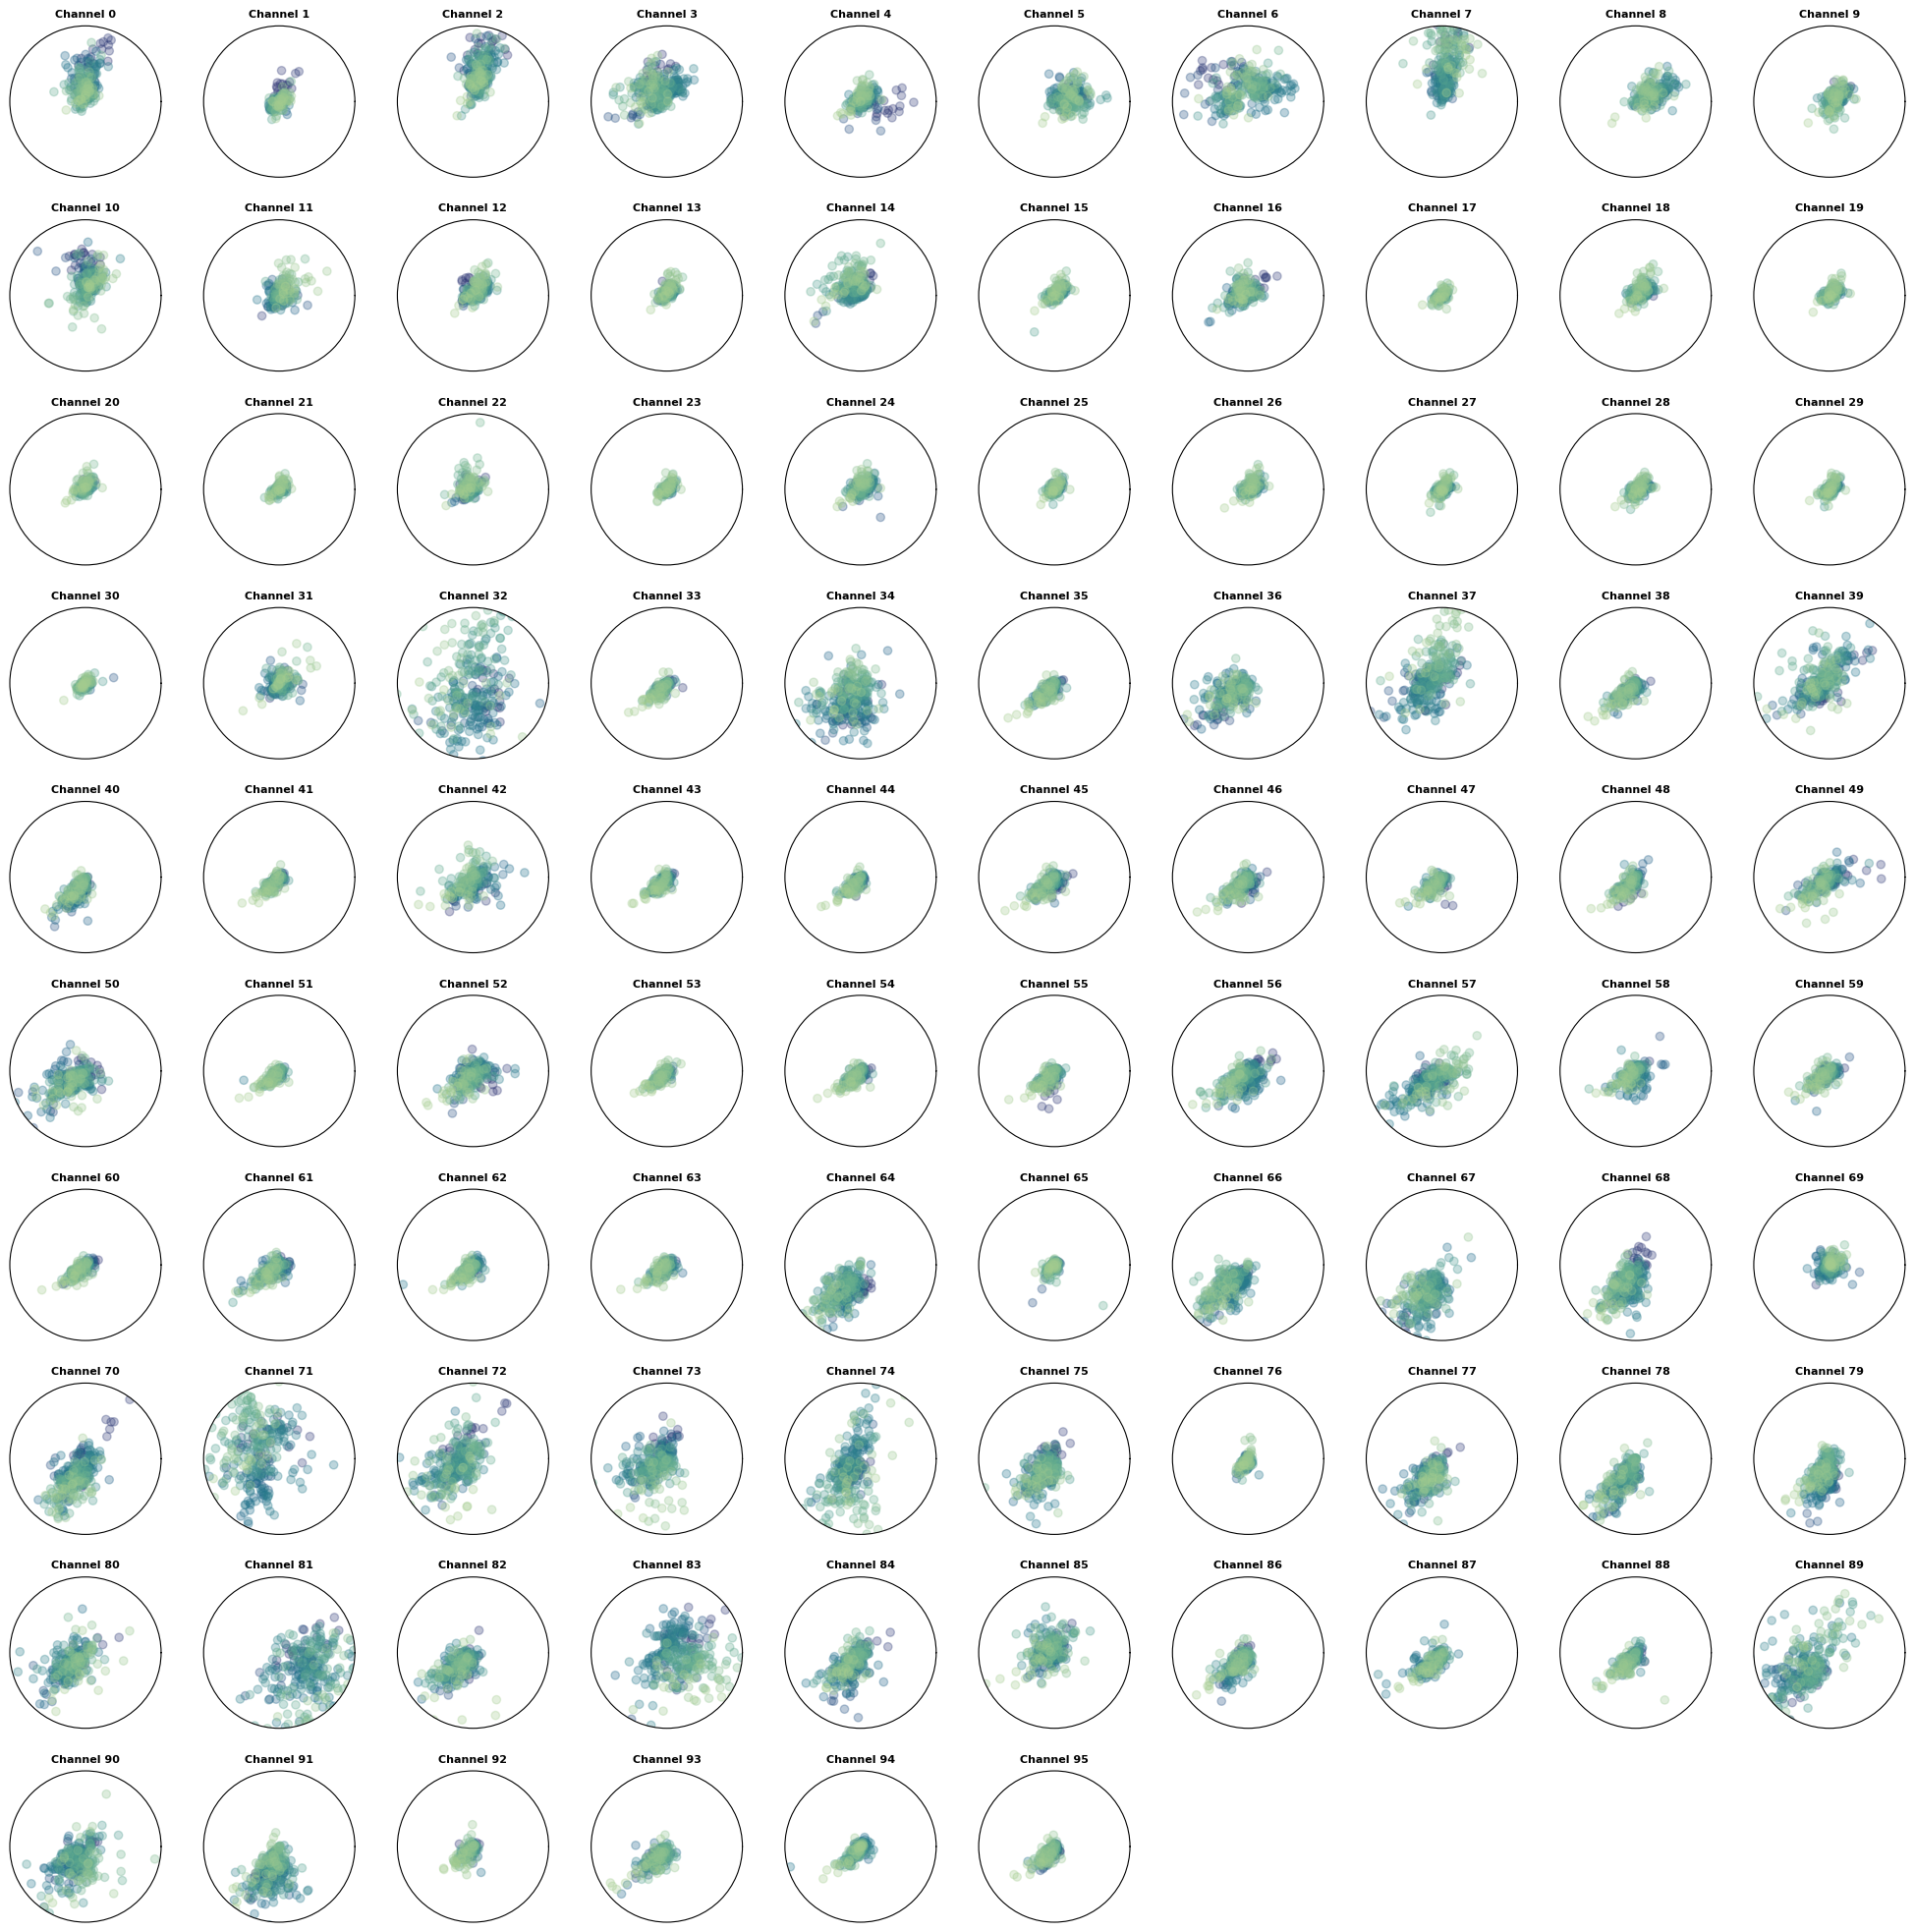

In [23]:
# Create a figure with subplots for all channels
num_channels = int(tuning_df['channel'].max() + 1)
num_cols = 10  # Number of columns in the grid
num_rows = (num_channels + num_cols - 1) // num_cols  # Calculate required rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20), subplot_kw={'polar': True})
axes = axes.flatten()  # Flatten the axes array for easy iteration

cmap = 'crest'

for i, channel in enumerate(range(num_channels)):
    stabtune_plotter.plot_polar_tuning(axes[i], tuning_df, channel, ylim=(min_magnitude, max_magnitude), cmap=cmap)
    axes[i].set_title(f'Channel {channel}', fontsize=8)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
# Hide any unused subplots
for ax in axes[num_channels:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Code to generate the big plot (WIP no toplevel plotter yet)

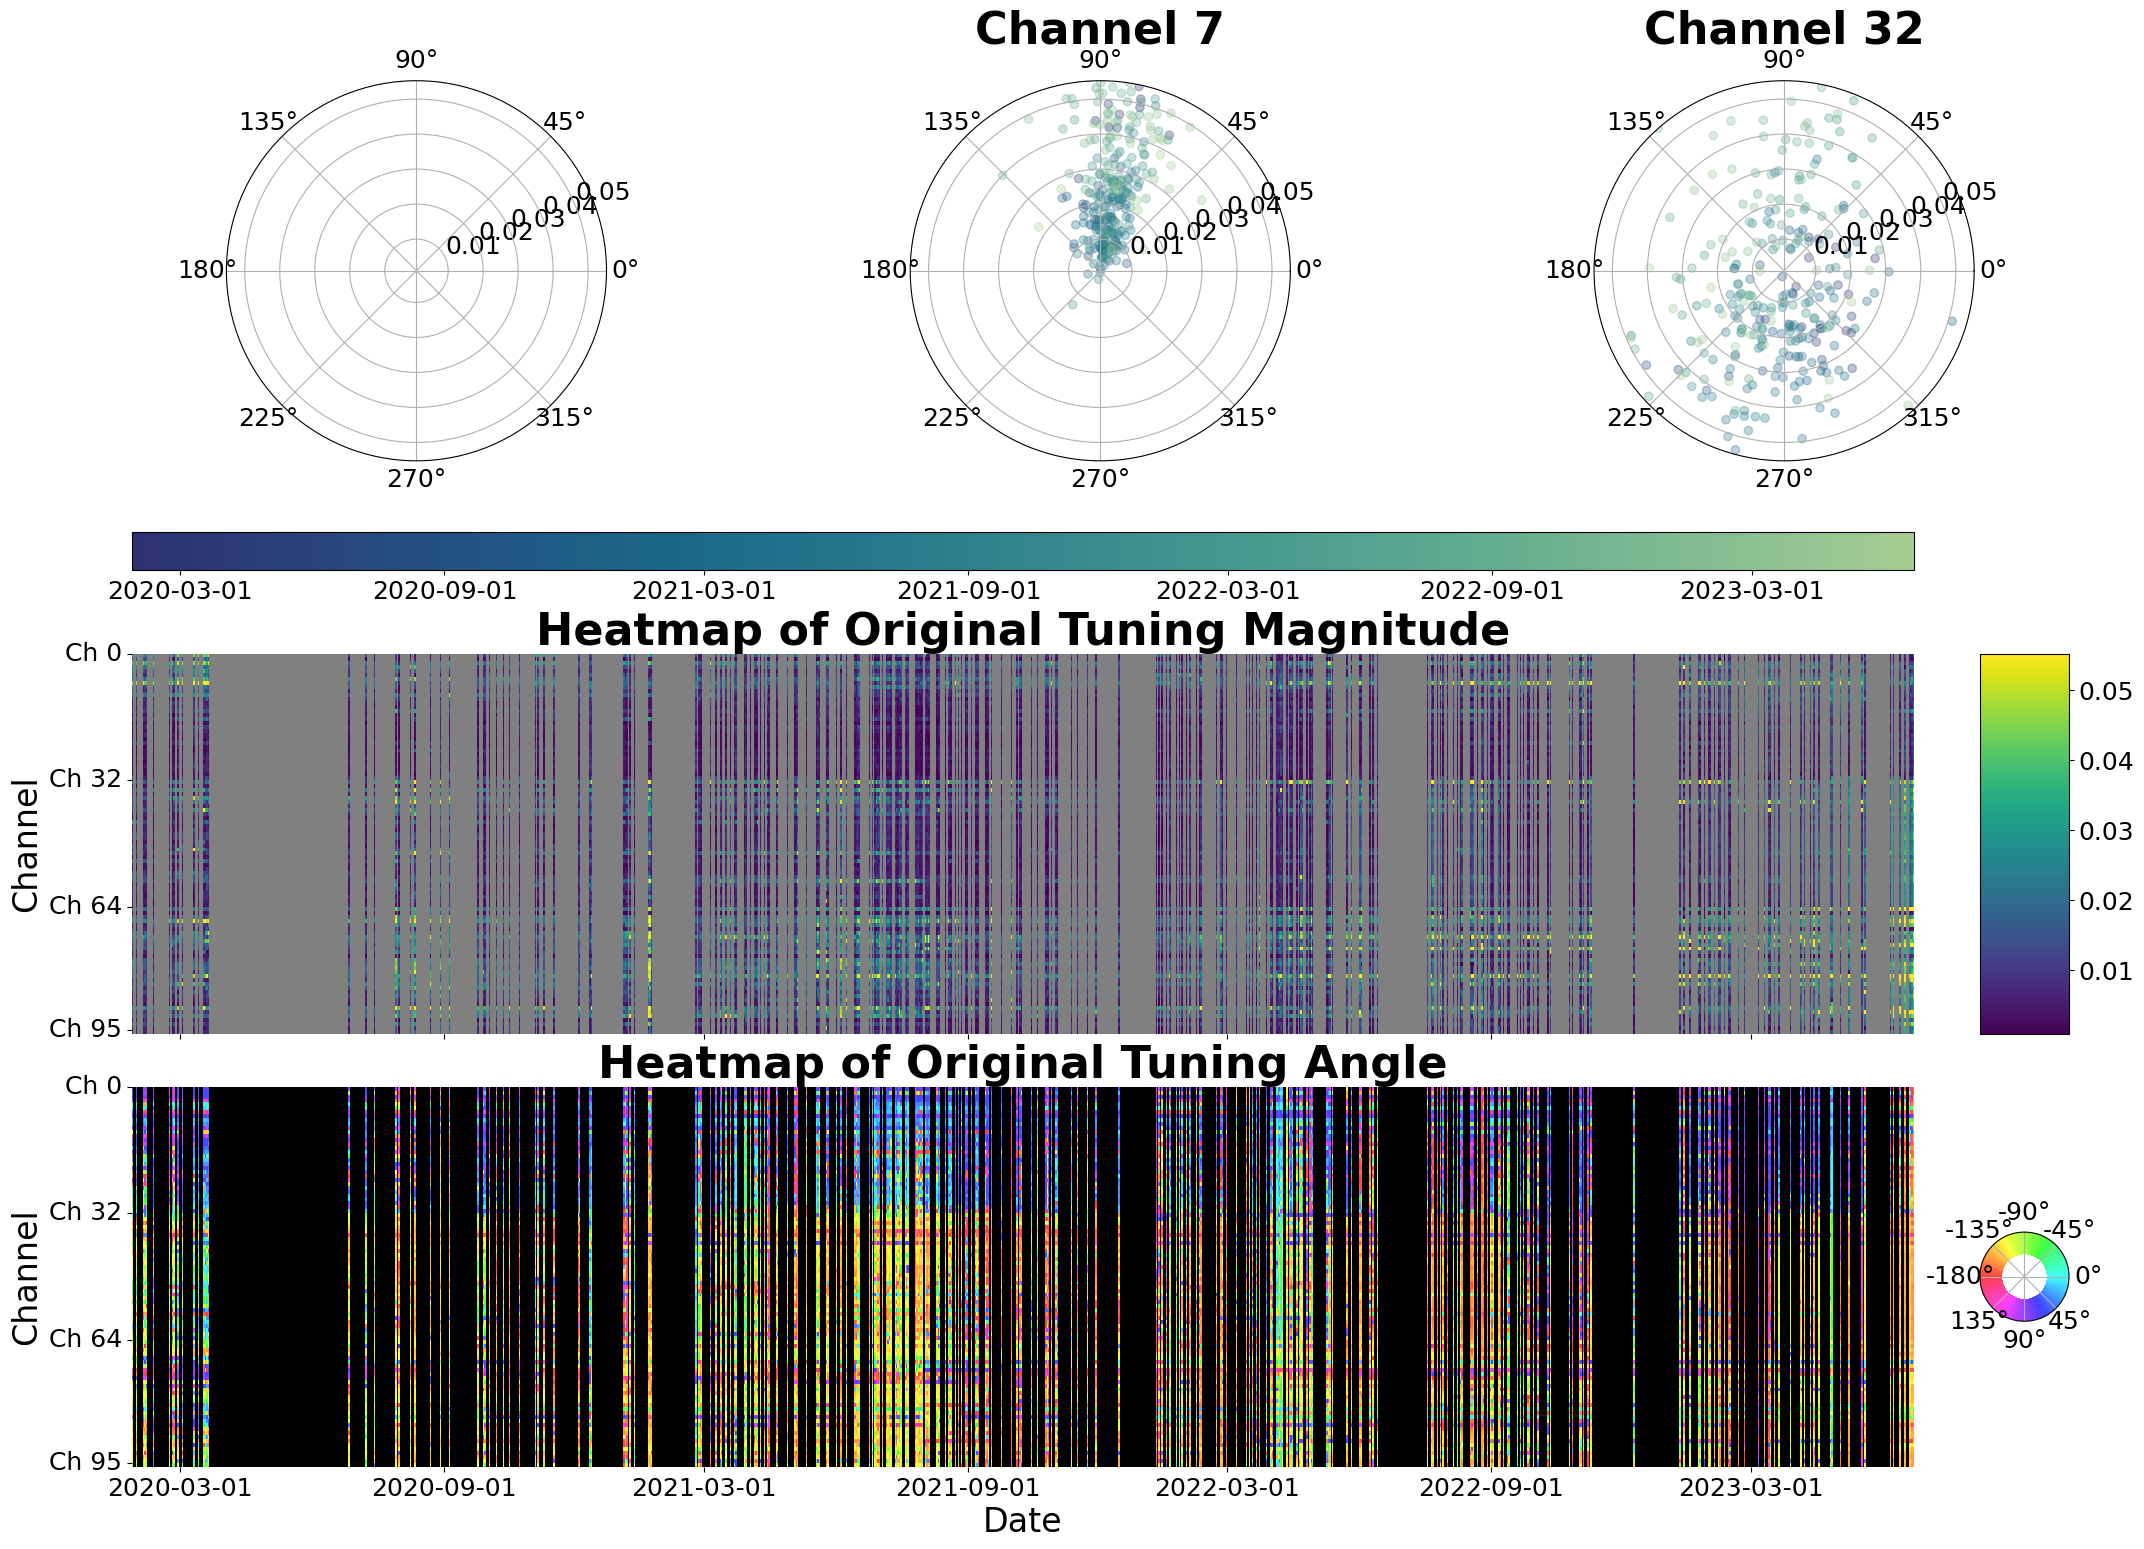

In [28]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
selected_channels = [-1,7,32]
constrained_flag = False
if(mpl.rcParams['figure.constrained_layout.use'] == True):
    mpl.rcParams['figure.constrained_layout.use'] = False
    constrained_flag = True
fig = plt.figure(figsize=(25, 18))  # Adjusted figure size for the additional row
gs = GridSpec(7, len(selected_channels), figure=fig, hspace=0.15, height_ratios=[1, 0.05,0.1,0.08, 1, 0.001,1])  # Added another row

ax_row1 = [fig.add_subplot(gs[0, i],polar=True) for i in range(len(selected_channels))]
ax_row2 = gs[4,:].subgridspec(1, 2, wspace=0.07, hspace=0, width_ratios=[20, 1])
ax_row3 = gs[6,:].subgridspec(1, 2, wspace=0.07, hspace=0, width_ratios=[20, 1])
ax_row2_left = fig.add_subplot(ax_row2[0])
ax_row3_left = fig.add_subplot(ax_row3[0])
ax_cbar = GridSpecFromSubplotSpec(1, 2, wspace=0.07, hspace=0, subplot_spec=gs[2,:], width_ratios=[20, 1])
cbar_ax = fig.add_subplot(ax_cbar[0])
cbar_ax2 = fig.add_subplot(ax_row2[1])
cwheel_ax = fig.add_subplot(ax_row3[1],polar=True)

cmap = 'crest'

stabtune_plotter.plot_polar_tuning(ax_row1[0], tuning_df, -1, ylim=(min_magnitude, max_magnitude), cmap=cmap)

for i, channel in enumerate(selected_channels[1:]):
    if ax_row1[i+1] is not None:  # Ensure the axes object is valid
        im = stabtune_plotter.plot_polar_tuning(ax_row1[i+1], tuning_df, channel, ylim=(min_magnitude, max_magnitude), cmap=cmap)

all_dates = pd.date_range(tuning_df['date'].min(), tuning_df['date'].max())
norm = colors.Normalize(vmin=0, vmax=len(all_dates) - 1)
sm = cm.ScalarMappable(cmap=sns.color_palette(cmap, as_cmap=True).reversed(), norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
xticks = [i for i, date in enumerate(all_dates) if date.month in [3, 9] and date.day == 1]
cbar.set_ticks(xticks)
cbar.set_ticklabels([all_dates[i].strftime('%Y-%m-%d') for i in xticks])

stabtune_plotter.plot_heat_map_uniform_Experimental(ax_row2_left, tuning_df, choice='original', type='magnitude', cmap='viridis', plot_xlabel = False, is_circle_cbar = True)

all_dates = pd.date_range(tuning_df['date'].min(), tuning_df['date'].max())
matrix    = (tuning_df.pivot(index='channel', columns='date', values='magnitude').reindex(columns=all_dates))
lower, upper = np.nanquantile(matrix.values, [0.01, 0.99])
norm = colors.Normalize(vmin=lower, vmax=upper)
sm = cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax2, orientation='vertical')

stabtune_plotter.plot_heat_map_uniform_Experimental(ax_row3_left, tuning_df, choice='original', type='angle', cmap=stabtune_utils.desaturate_hsv(), is_circle_cbar = True)

stabtune_plotter.draw_angle_wheel(cwheel_ax, stabtune_utils.desaturate_hsv())

plt.savefig(os.path.join(output_dir, 'tuning_analysis.pdf'))
if(constrained_flag):
    mpl.rcParams['figure.constrained_layout.use'] = True

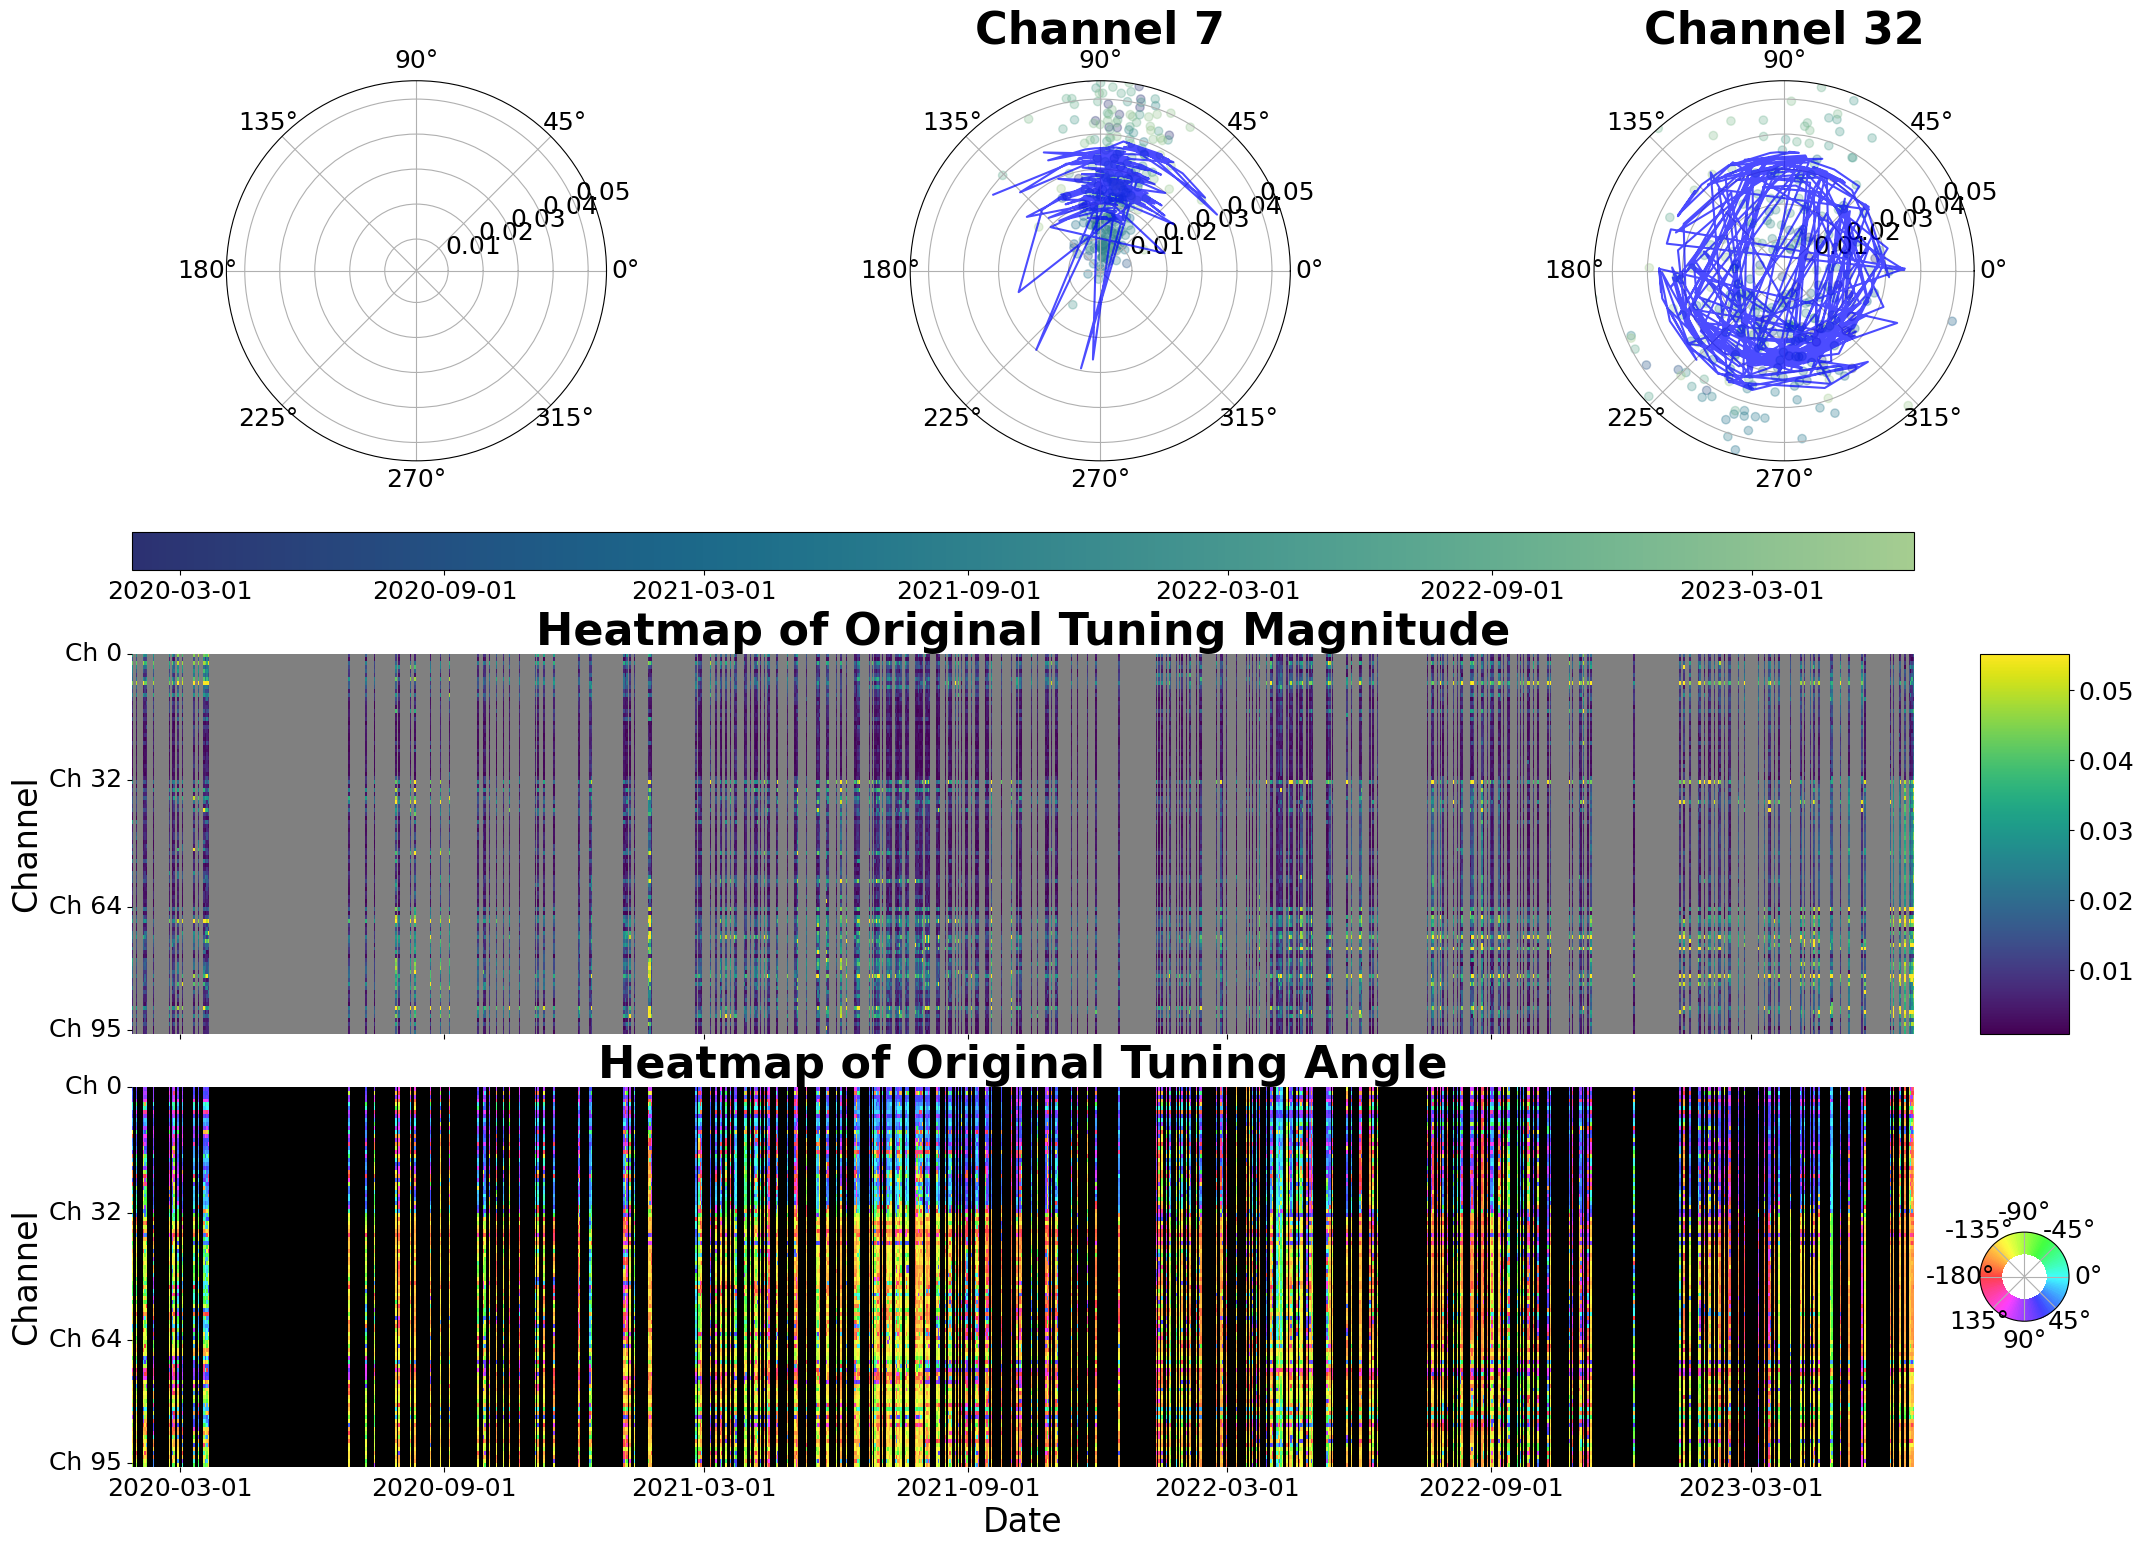

In [32]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
selected_channels = [-1,7,32]
constrained_flag = False
if(mpl.rcParams['figure.constrained_layout.use'] == True):
    mpl.rcParams['figure.constrained_layout.use'] = False
    constrained_flag = True
fig = plt.figure(figsize=(25, 18))  # Adjusted figure size for the additional row
gs = GridSpec(7, len(selected_channels), figure=fig, hspace=0.15, height_ratios=[1, 0.05,0.1,0.08, 1, 0.001,1])  # Added another row

ax_row1 = [fig.add_subplot(gs[0, i],polar=True) for i in range(len(selected_channels))]
ax_row2 = gs[4,:].subgridspec(1, 2, wspace=0.07, hspace=0, width_ratios=[20, 1])
ax_row3 = gs[6,:].subgridspec(1, 2, wspace=0.07, hspace=0, width_ratios=[20, 1])
ax_row2_left = fig.add_subplot(ax_row2[0])
ax_row3_left = fig.add_subplot(ax_row3[0])
ax_cbar = GridSpecFromSubplotSpec(1, 2, wspace=0.07, hspace=0, subplot_spec=gs[2,:], width_ratios=[20, 1])
cbar_ax = fig.add_subplot(ax_cbar[0])
cbar_ax2 = fig.add_subplot(ax_row2[1])
cwheel_ax = fig.add_subplot(ax_row3[1],polar=True)

cmap = 'crest'

stabtune_plotter.plot_polar_tuning(ax_row1[0], tuning_df, -1, ylim=(min_magnitude, max_magnitude), cmap=cmap)

for i, channel in enumerate(selected_channels[1:]):
    if ax_row1[i+1] is not None:  # Ensure the axes object is valid
        im = stabtune_plotter.plot_polar_tuning_fit(ax_row1[i+1], tuning_df, channel, ylim=(min_magnitude, max_magnitude), cmap=cmap)

all_dates = pd.date_range(tuning_df['date'].min(), tuning_df['date'].max())
norm = colors.Normalize(vmin=0, vmax=len(all_dates) - 1)
sm = cm.ScalarMappable(cmap=sns.color_palette(cmap, as_cmap=True).reversed(), norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
xticks = [i for i, date in enumerate(all_dates) if date.month in [3, 9] and date.day == 1]
cbar.set_ticks(xticks)
cbar.set_ticklabels([all_dates[i].strftime('%Y-%m-%d') for i in xticks])

stabtune_plotter.plot_heat_map_uniform_Experimental(ax_row2_left, tuning_df, choice='original', type='magnitude', cmap='viridis', plot_xlabel = False, is_circle_cbar = True)

all_dates = pd.date_range(tuning_df['date'].min(), tuning_df['date'].max())
matrix    = (tuning_df.pivot(index='channel', columns='date', values='magnitude').reindex(columns=all_dates))
lower, upper = np.nanquantile(matrix.values, [0.01, 0.99])
norm = colors.Normalize(vmin=lower, vmax=upper)
sm = cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax2, orientation='vertical')

stabtune_plotter.plot_heat_map_uniform_Experimental(ax_row3_left, tuning_df, choice='original', type='angle', cmap=stabtune_utils.desaturate_hsv(), is_circle_cbar = True)

stabtune_plotter.draw_angle_wheel(cwheel_ax, stabtune_utils.desaturate_hsv())

plt.savefig(os.path.join(output_dir, 'tuning_analysis_trace.pdf'))
if(constrained_flag):
    mpl.rcParams['figure.constrained_layout.use'] = True

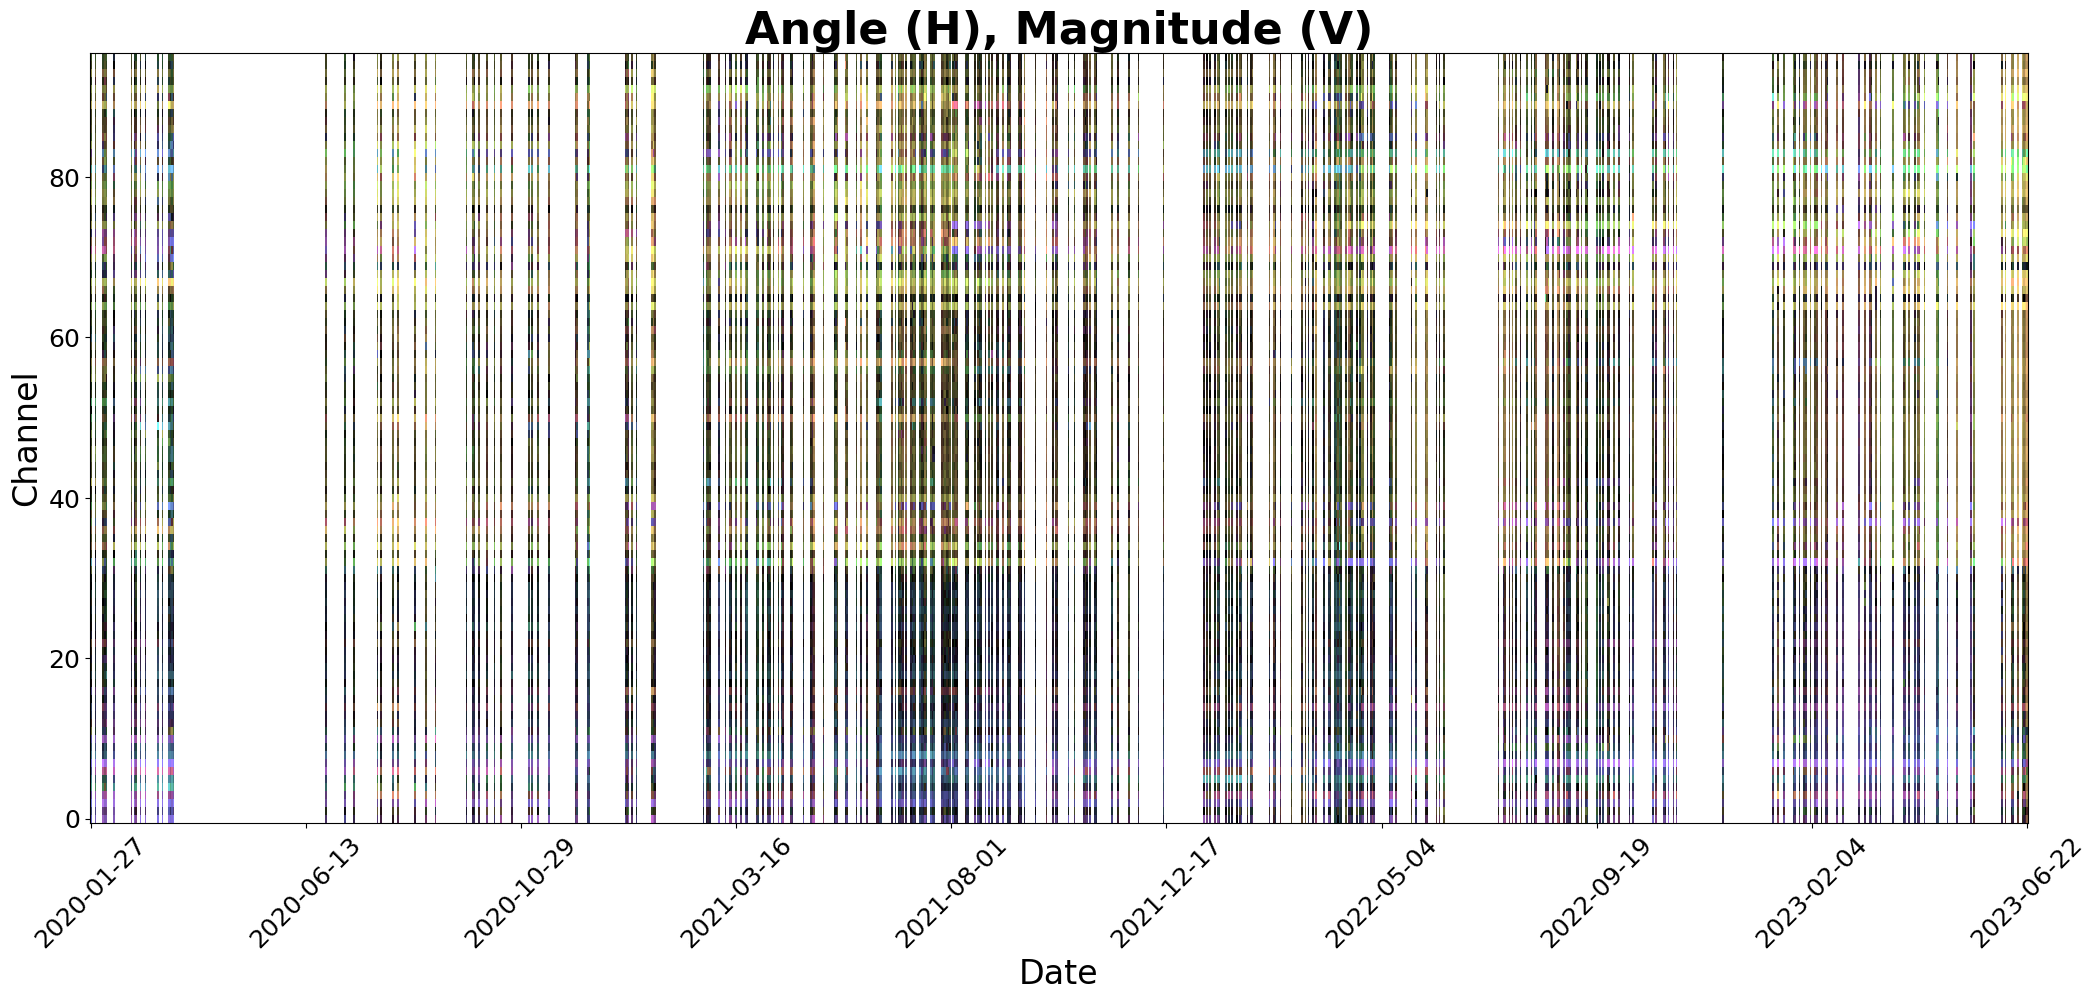

In [9]:
fig, ax = plt.subplots(figsize=(25, 10))

stabtune_plotter.plot_heat_map_HSV(ax, tuning_df,sat=0.5)

### Time graphs (seperated by 32)

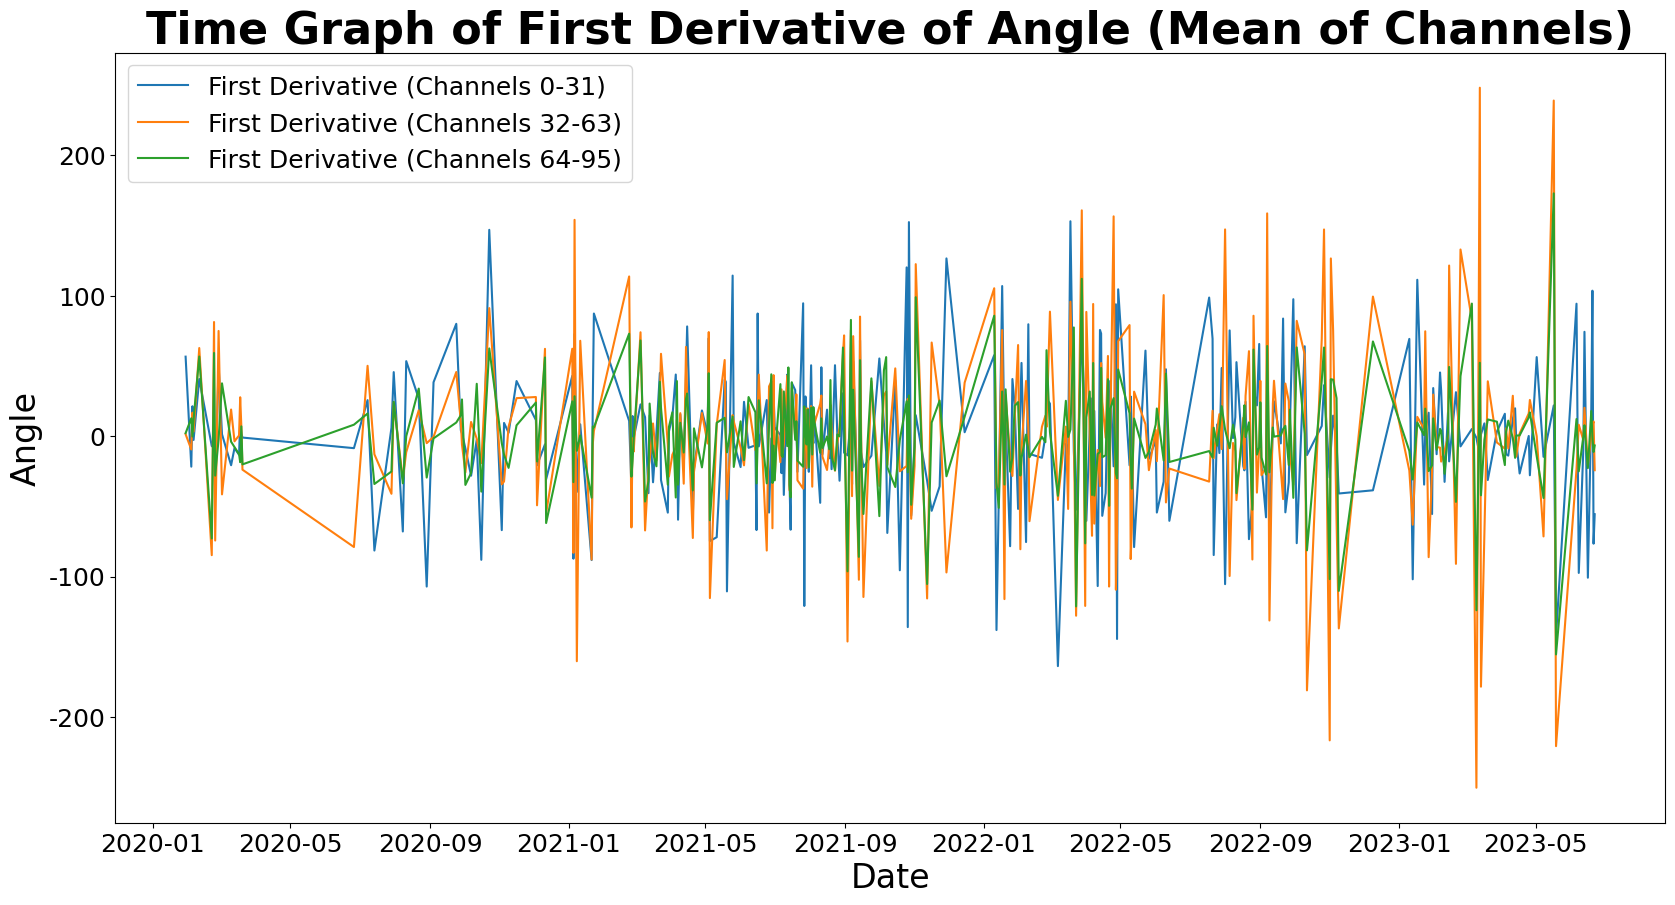

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
stabtune_plotter.plot_time_graph(ax, tuning_df, derivative='first_derivative', type='angle', channels=list(range(0, 32)))
stabtune_plotter.plot_time_graph(ax, tuning_df, derivative='first_derivative', type='angle', channels=list(range(32, 64)))
stabtune_plotter.plot_time_graph(ax, tuning_df, derivative='first_derivative', type='angle', channels=list(range(64, 96)))

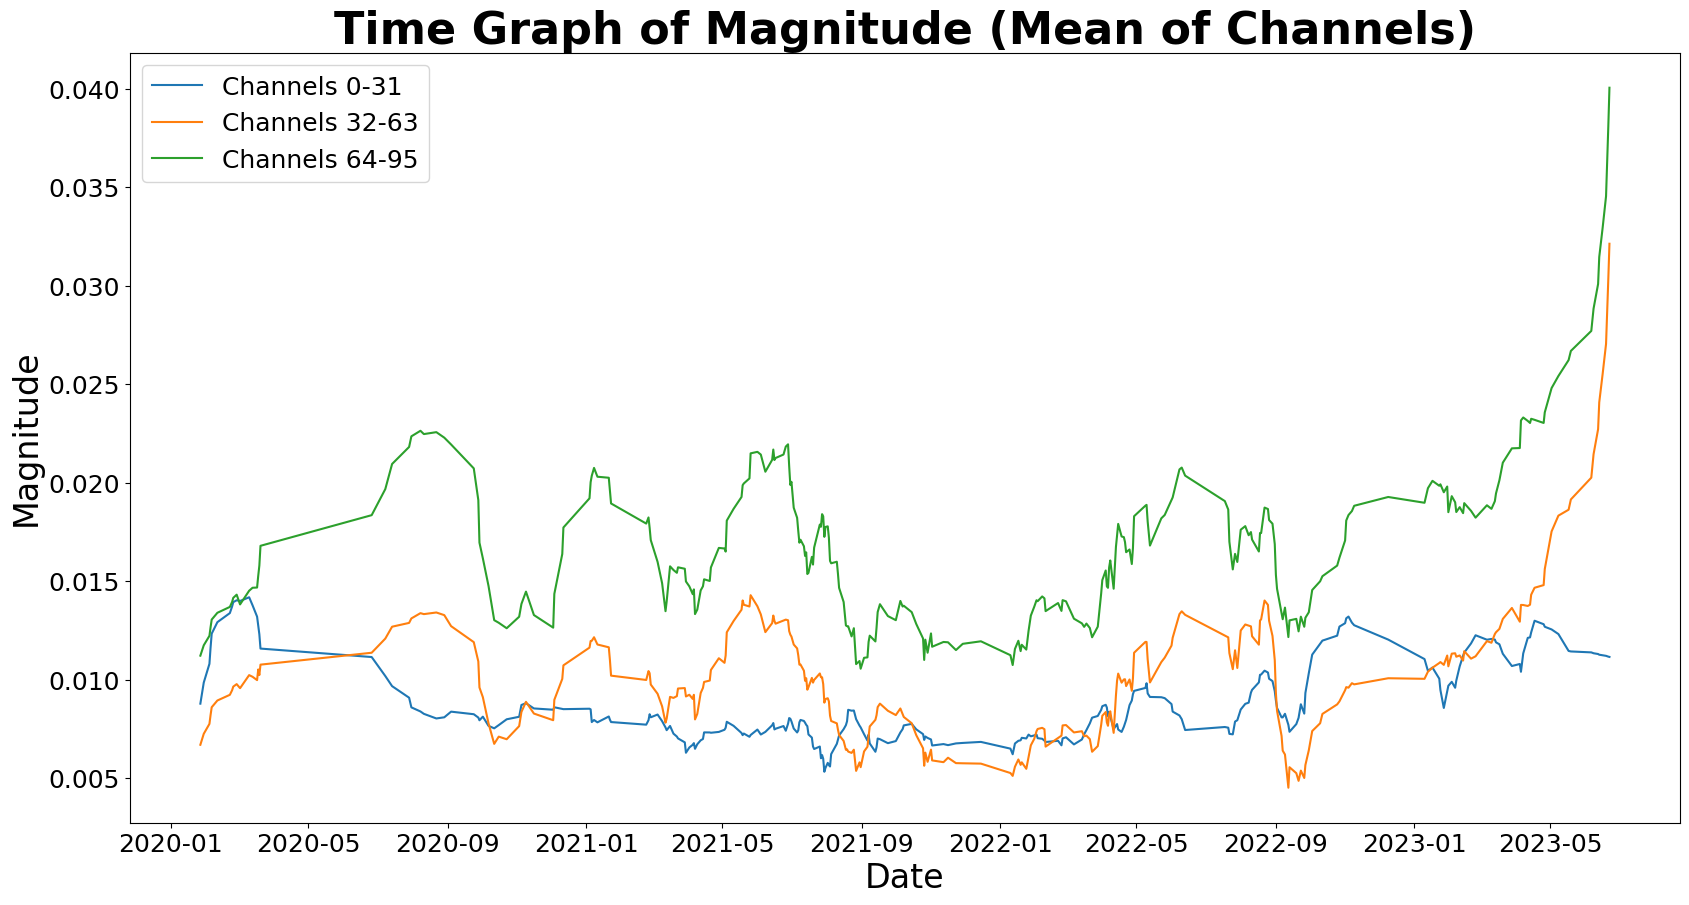

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
smoothing_params = {'window_length': 20, 'polyorder': 2}
stabtune_plotter.plot_time_graph(ax, tuning_df, derivative='original', type='magnitude', channels=list(range(0, 32)), apply_smoothing=True, smoothing_params=smoothing_params)
stabtune_plotter.plot_time_graph(ax, tuning_df, derivative='original', type='magnitude', channels=list(range(32, 64)), apply_smoothing=True, smoothing_params=smoothing_params)
stabtune_plotter.plot_time_graph(ax, tuning_df, derivative='original', type='magnitude', channels=list(range(64, 96)), apply_smoothing=True, smoothing_params=smoothing_params)


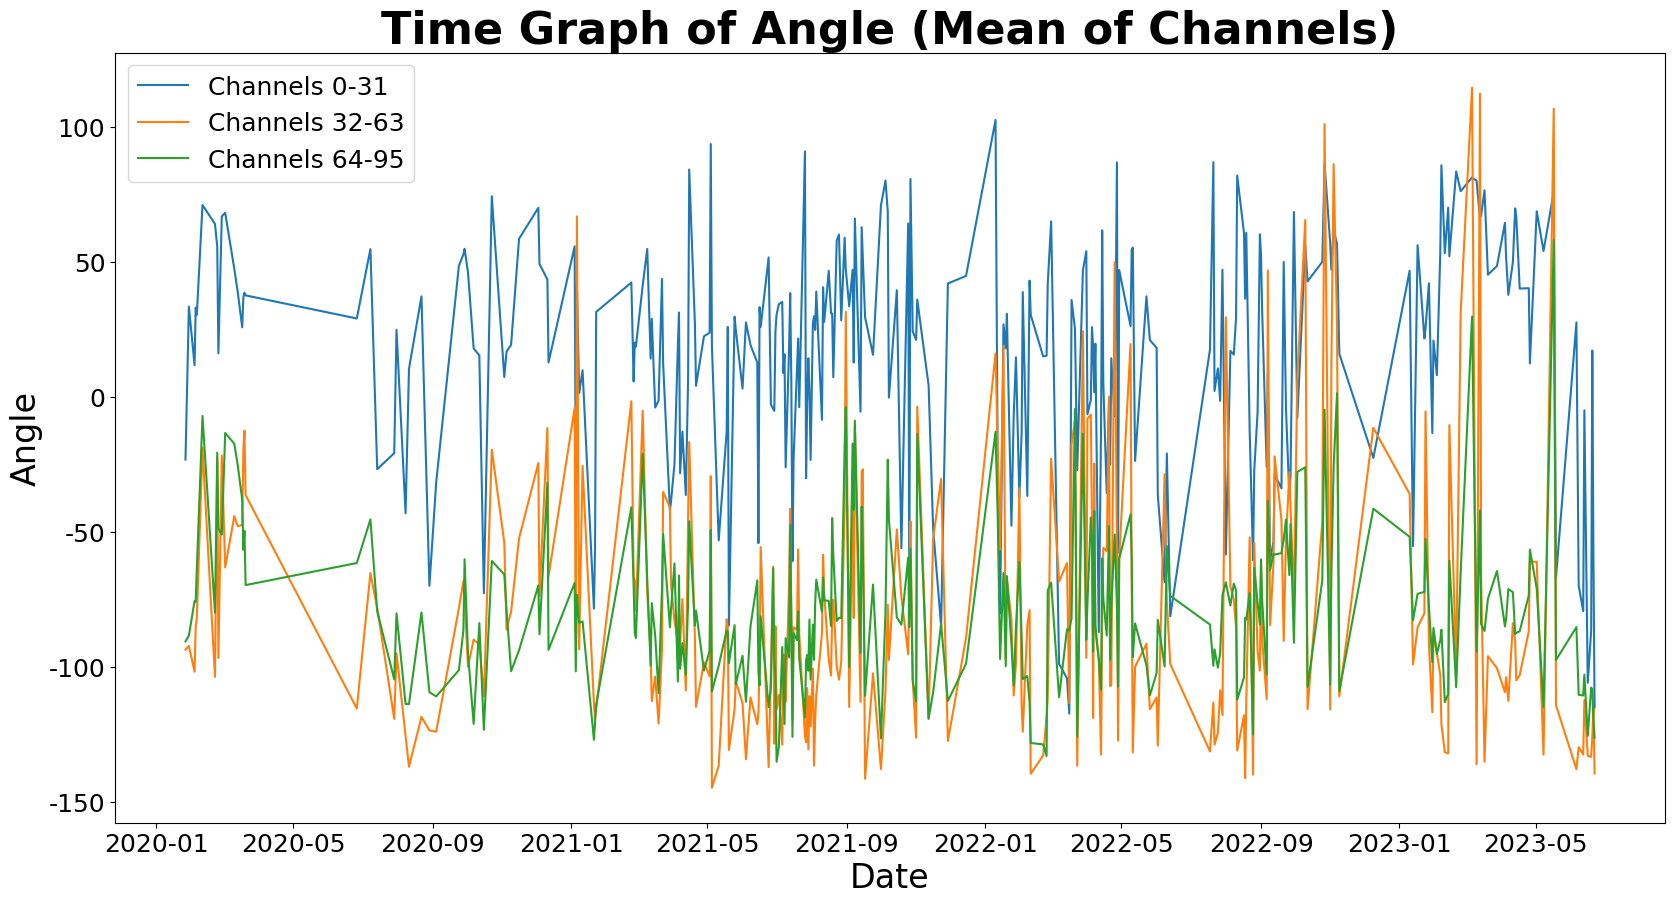

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
stabtune_plotter.plot_time_graph(ax, tuning_df, derivative='original', type='angle', channels=list(range(0, 32)))
stabtune_plotter.plot_time_graph(ax, tuning_df, derivative='original', type='angle', channels=list(range(32, 64)))
stabtune_plotter.plot_time_graph(ax, tuning_df, derivative='original', type='angle', channels=list(range(64, 96)))

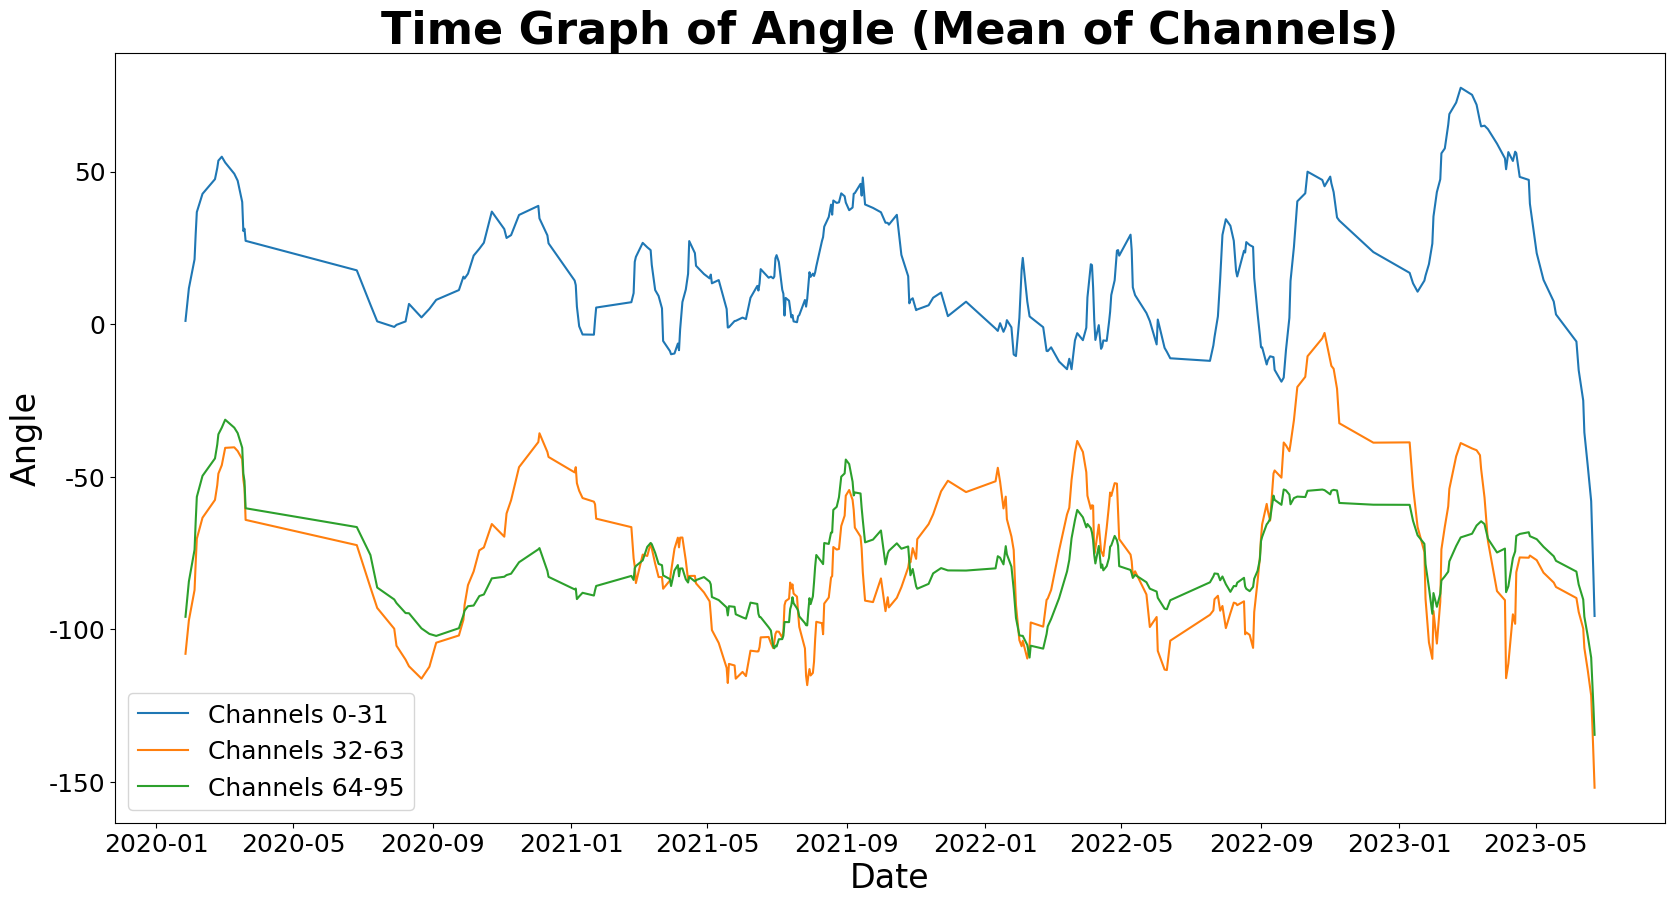

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
smoothing_params = {'window_length': 20, 'polyorder': 2}
stabtune_plotter.plot_time_graph(ax, tuning_df, derivative='original', type='angle', channels=list(range(0, 32)), apply_smoothing=True, smoothing_params=smoothing_params)
stabtune_plotter.plot_time_graph(ax, tuning_df, derivative='original', type='angle', channels=list(range(32, 64)), apply_smoothing=True, smoothing_params=smoothing_params)
stabtune_plotter.plot_time_graph(ax, tuning_df, derivative='original', type='angle', channels=list(range(64, 96)), apply_smoothing=True, smoothing_params=smoothing_params)

### Nicholas' Stuff

c:\Files\UM\ND\github\big_nhp_dataset_code\analysis\singlechanneltuning\stabtune_plotter.py:451: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  angles = df_tuning['angle'].loc[time_point][:50].values  # First 5 channels
c:\Files\UM\ND\github\big_nhp_dataset_code\analysis\singlechanneltuning\stabtune_plotter.py:452: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  magnitudes = df_tuning['magnitude'].loc[time_point][:50].values


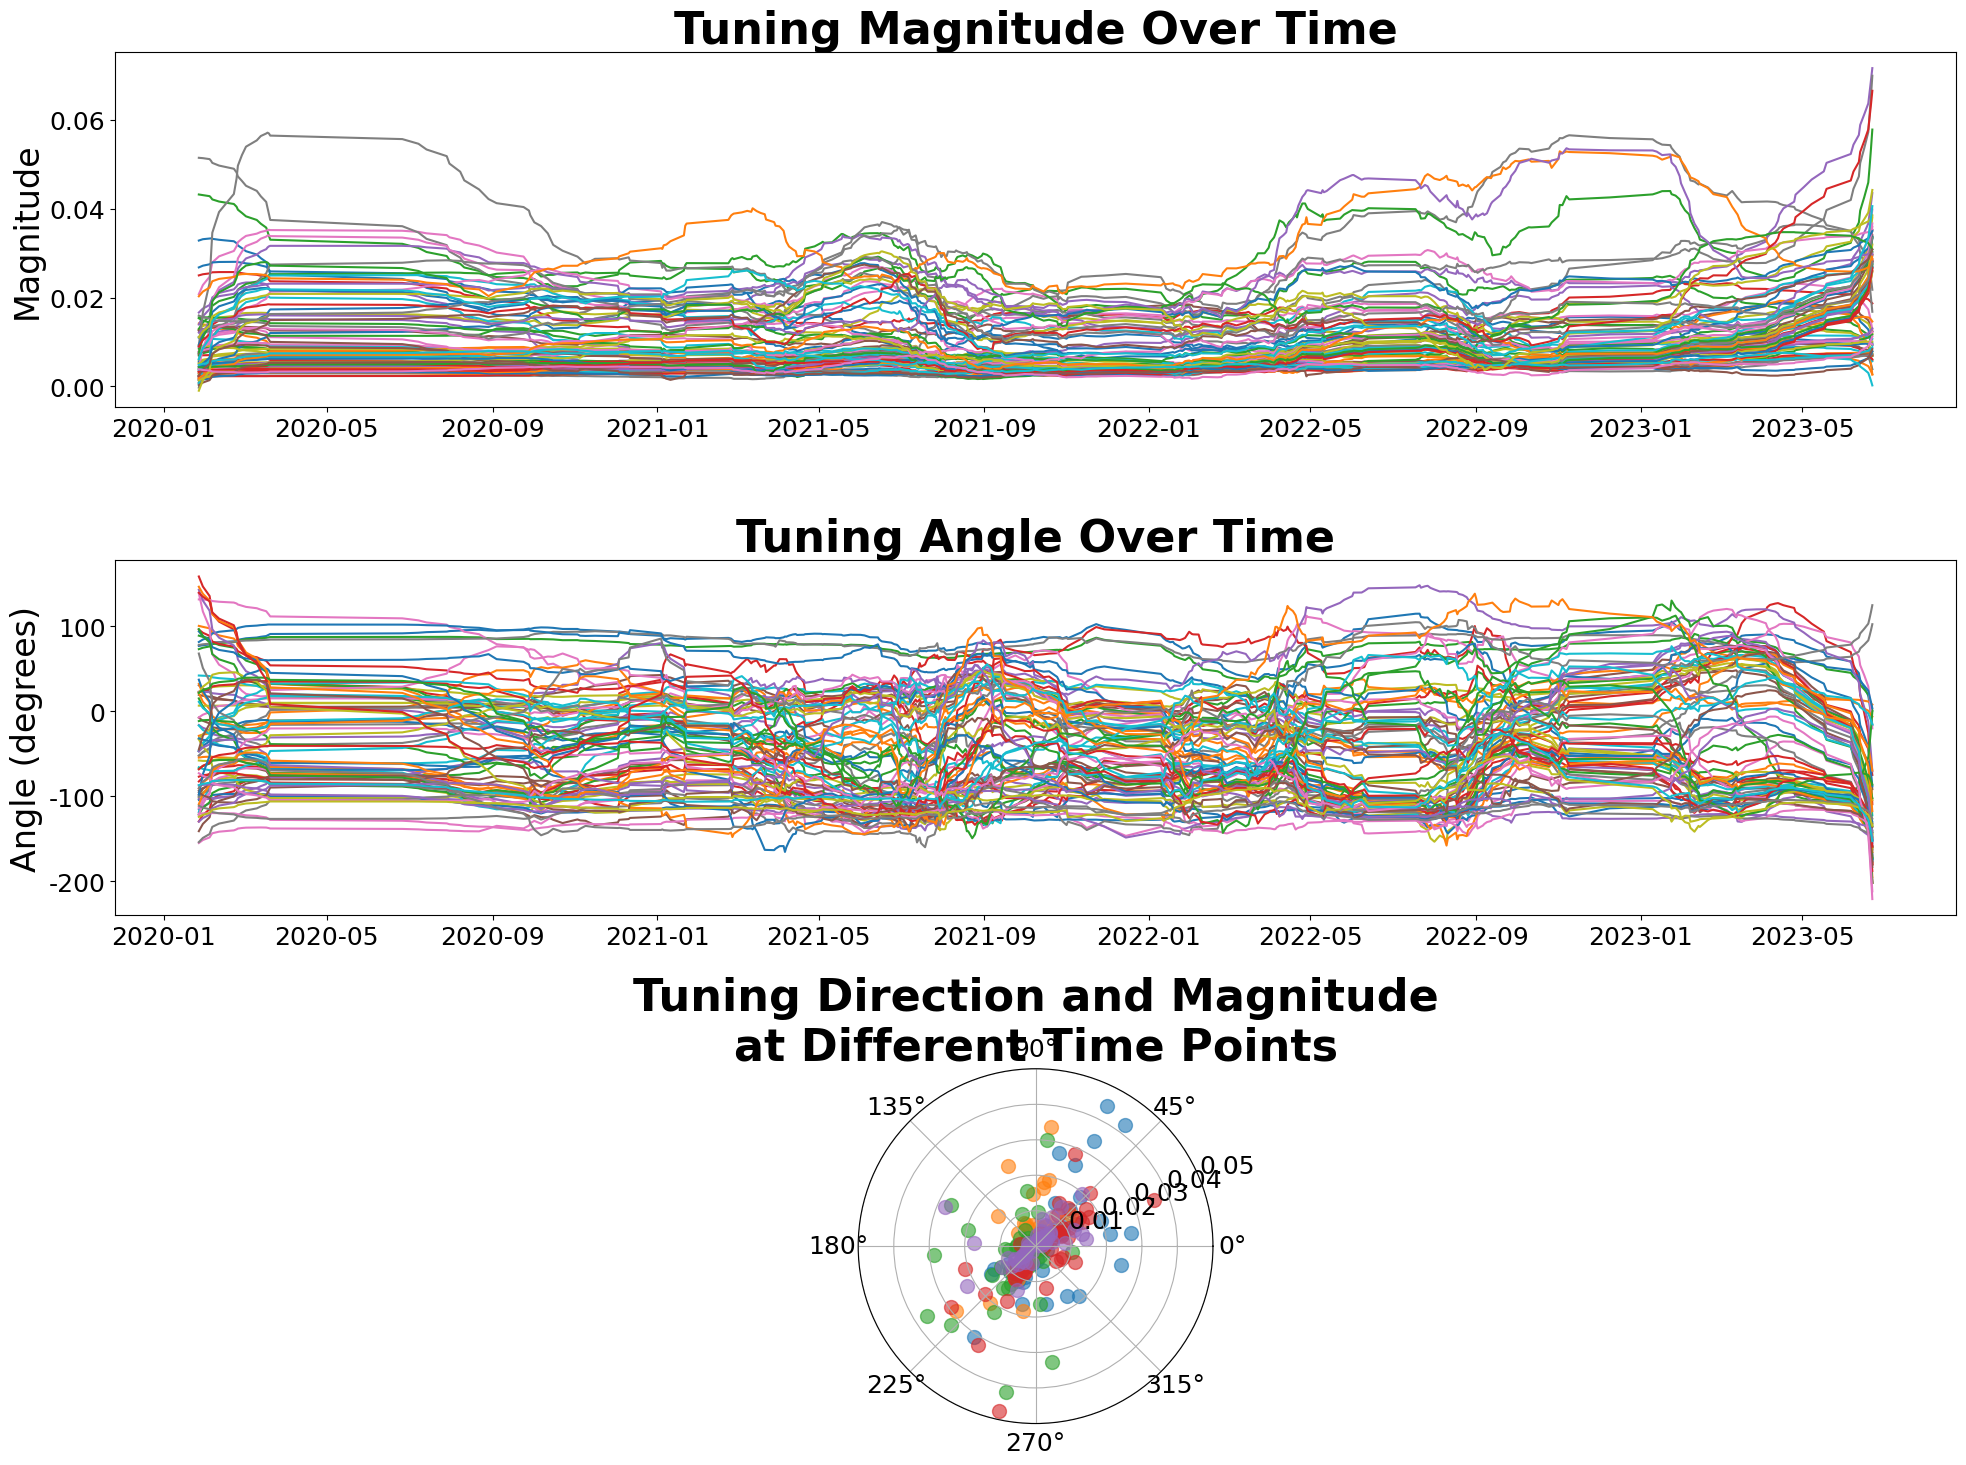

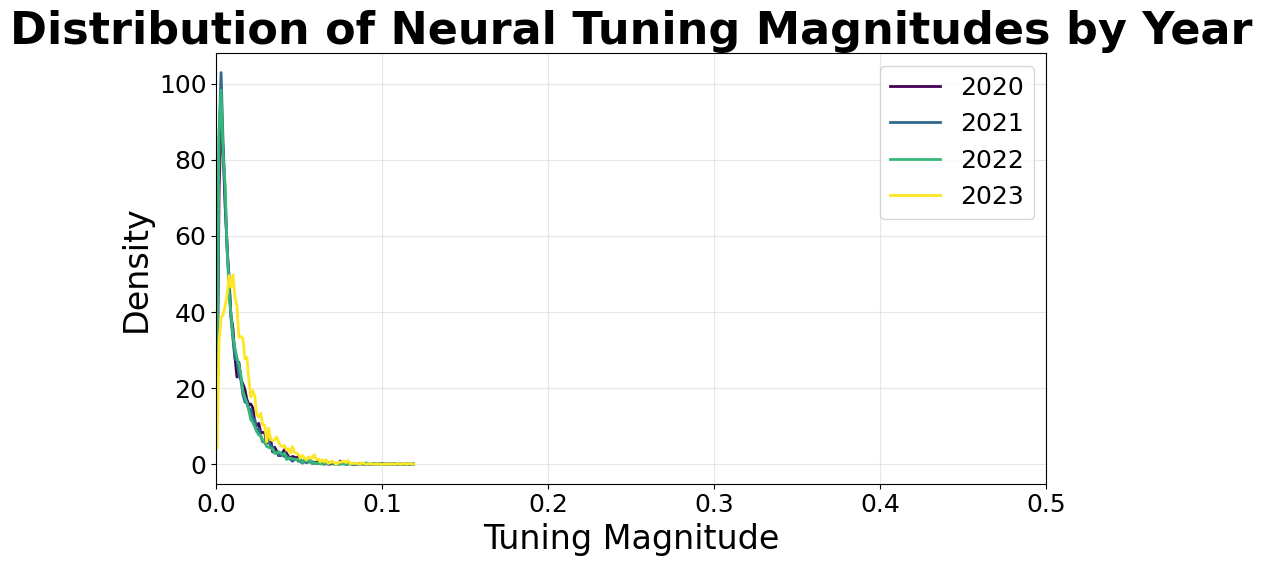


## Yearly Means ##
Year 2020: 0.0121
Year 2021: 0.0109
Year 2022: 0.0110
Year 2023: 0.0167

## Distribution Comparisons Between Years ##
Years        JS Div     KS Stat    KS p-val   t-stat     t p-val    Mean Diff 
------------------------------------------------------------------------
2020-2021    0.0443    0.0455    7.30e-06  5.5433    3.08e-08  -0.0011
2020-2022    0.0506    0.0462    8.82e-06  4.8111    1.53e-06  -0.0010
2020-2023    0.1744    0.2268    1.26e-95  -16.7429    6.56e-62  0.0046
2021-2022    0.0313    0.0110    5.59e-01  -0.7316    4.64e-01  0.0001
2021-2023    0.2068    0.2660    6.74e-195  -24.8023    1.04e-129  0.0058
2022-2023    0.2029    0.2670    1.06e-186  -23.5951    1.58e-118  0.0057


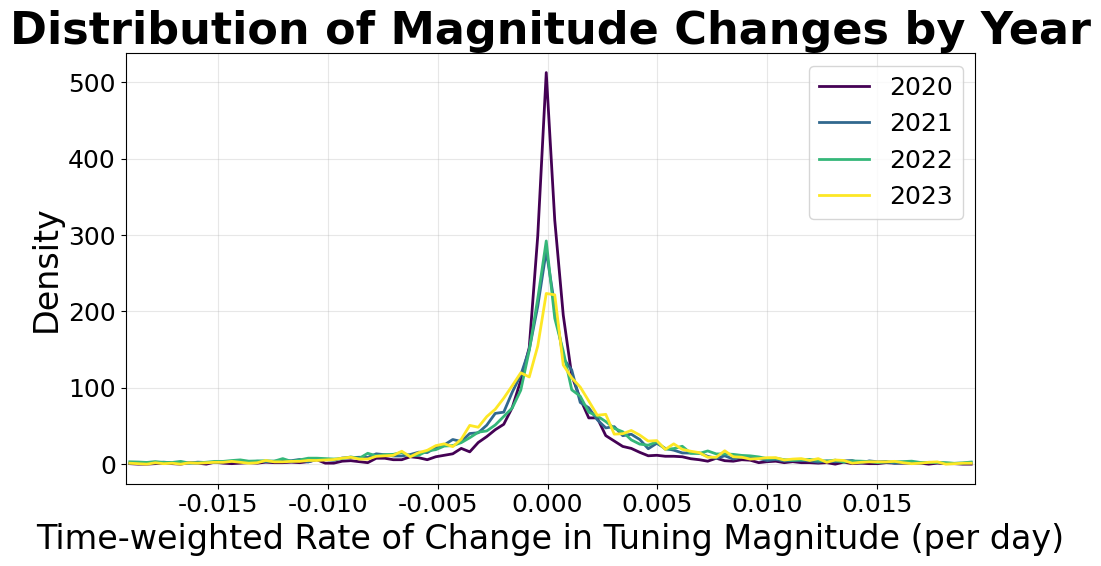


## Yearly Mean Rates of Change ##
Year 2020: 0.000086 per day
Year 2021: -0.000005 per day
Year 2022: 0.000036 per day
Year 2023: 0.000315 per day

## Time-Weighted Rate Comparisons ##
Years        JS Div     t-stat     t p-val    Mean Diff 
------------------------------------------------------------
2020-2021    0.1641    1.0843    2.78e-01  -0.000091
2020-2022    0.1744    0.5354    5.92e-01  -0.000050
2020-2023    0.1907    -2.2678    2.34e-02  0.000228
2021-2022    0.0560    -0.4476    6.54e-01  0.000041
2021-2023    0.0752    -3.2408    1.20e-03  0.000320
2022-2023    0.0924    -2.6036    9.24e-03  0.000279


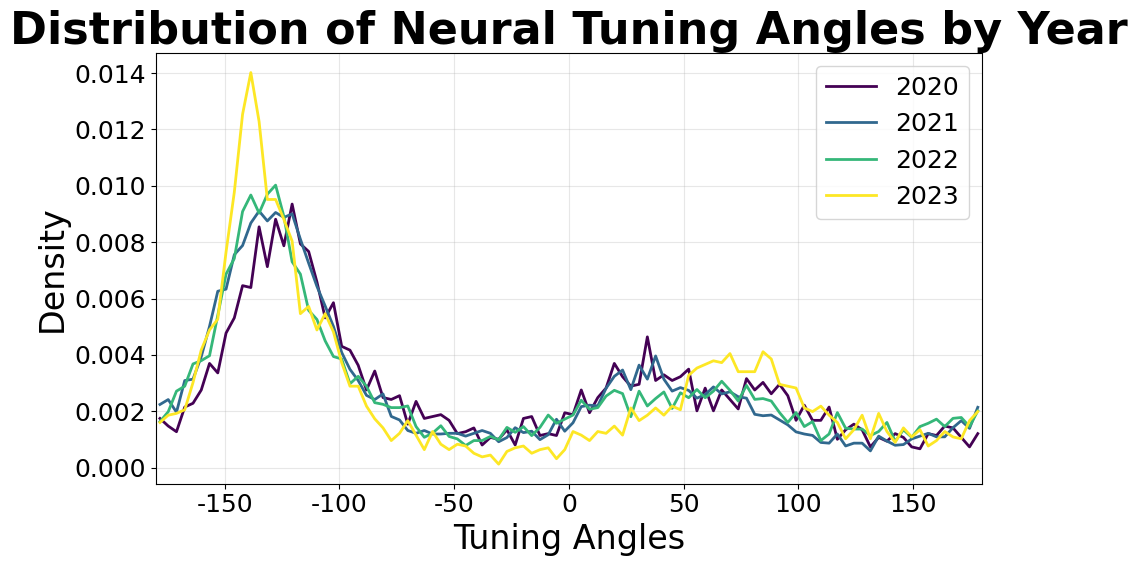


## Yearly Mean Angles ##
Year 2020: -39.89 degrees
Year 2021: -51.21 degrees
Year 2022: -45.20 degrees
Year 2023: -46.29 degrees

## Angular Distribution Comparisons ##
Years        JS Div     t-stat     t p-val    Mean Diff 
------------------------------------------------------------
2020-2021    0.0961    6.3262    2.66e-10  -11.32
2020-2022    0.1042    2.8597    4.25e-03  -5.31
2020-2023    0.1677    2.8724    4.08e-03  -6.40
2021-2022    0.0746    -4.2424    2.22e-05  6.01
2021-2023    0.1513    -2.6198    8.82e-03  4.92
2022-2023    0.1269    0.5618    5.74e-01  -1.09


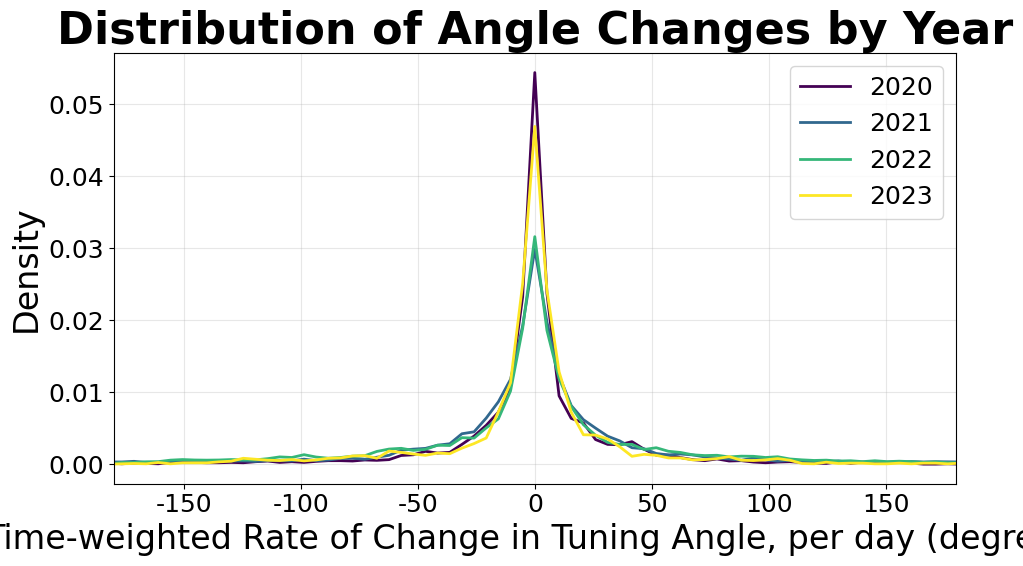


## Yearly Mean Rates of Change ##
Year 2020: -1.381599 per day
Year 2021: 0.654139 per day
Year 2022: 0.020016 per day
Year 2023: -1.735075 per day

## Time-Weighted Rate Comparisons ##
Years        JS Div     t-stat     t p-val    Mean Diff 
------------------------------------------------------------
2020-2021    0.1516    -1.9476    5.15e-02  2.035738
2020-2022    0.1719    -1.3665    1.72e-01  1.401615
2020-2023    0.1125    0.2995    7.65e-01  -0.353476
2021-2022    0.0866    0.6227    5.34e-01  -0.634123
2021-2023    0.1423    2.0350    4.19e-02  -2.389214
2022-2023    0.1478    1.5173    1.29e-01  -1.755090
Mean of Mean Day-to-Day Changes:  33.0120006420262 Mean of Mean Month-to-Month Changes:  33.208105250397146


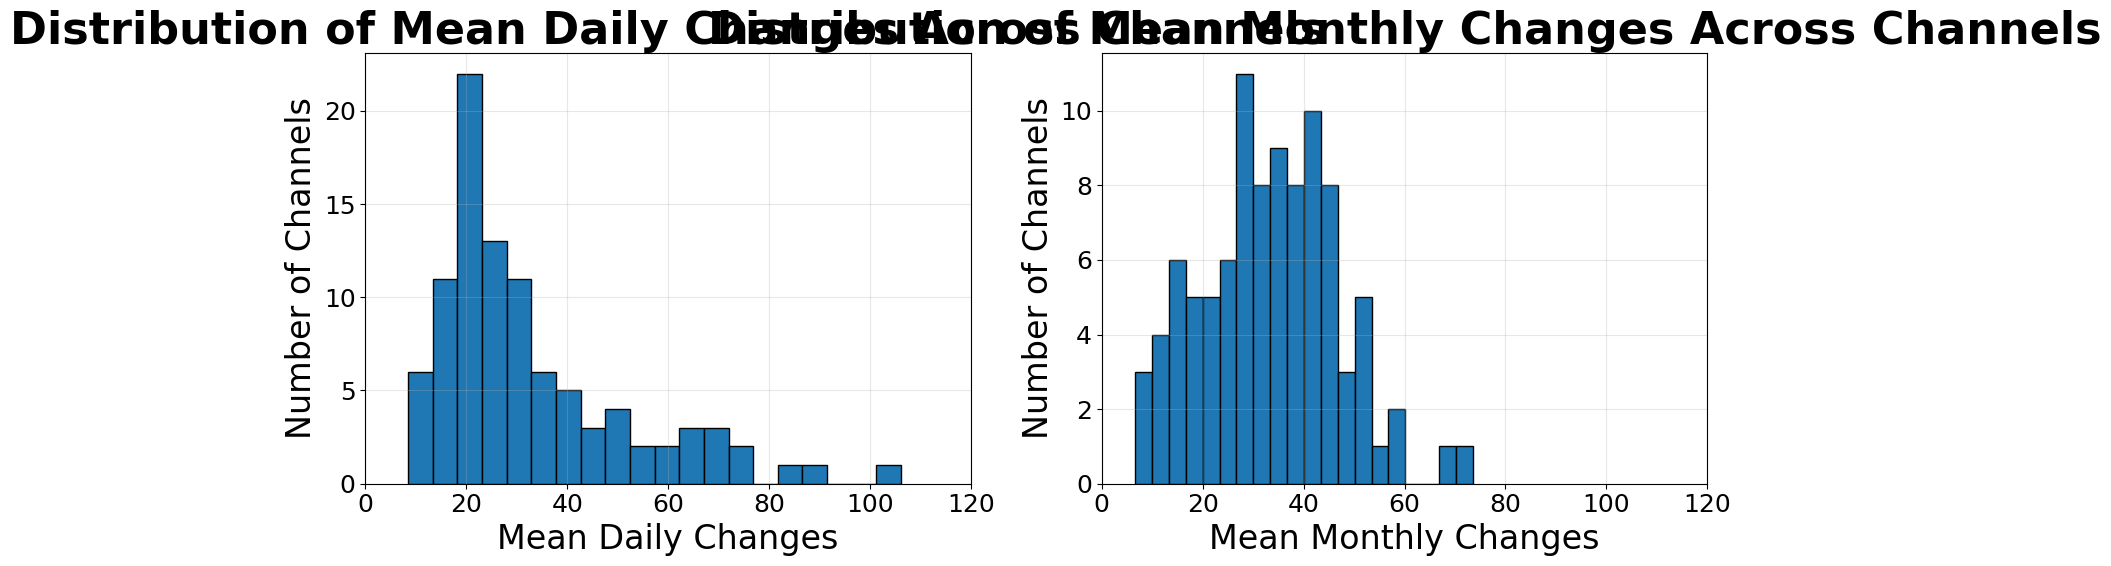


Daily Changes Summary:
Mean: 33.0120
Std: 19.5392
Min: 8.4869
Max: 106.1613

Monthly Changes Summary:
Mean: 33.2081
Std: 13.4792
Min: 6.6174
Max: 73.5307


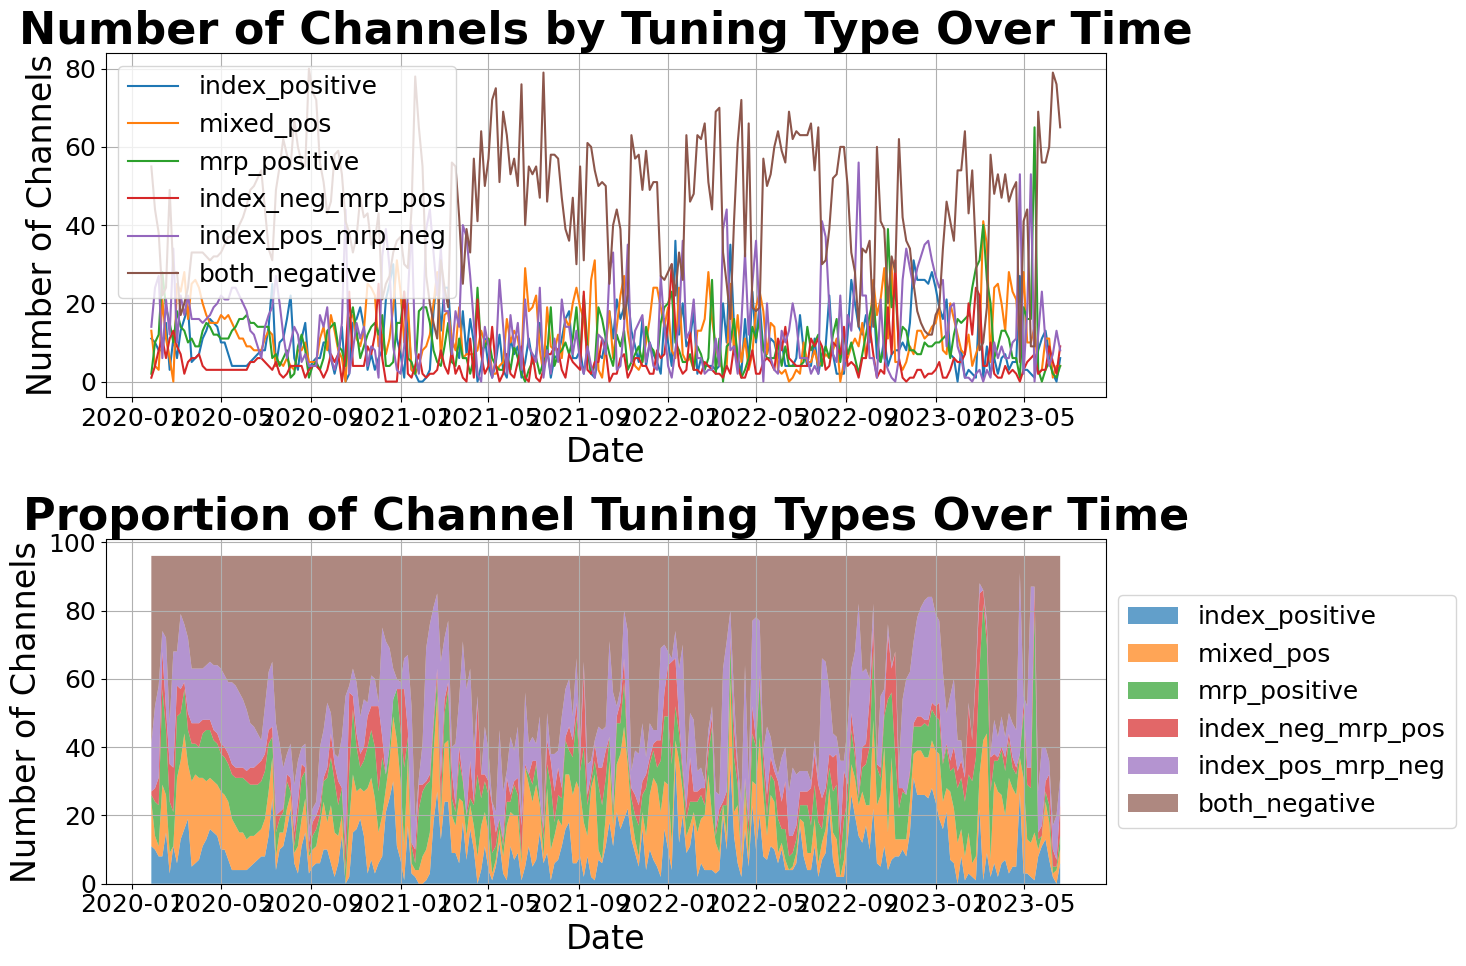


Average number of channels in each category:
index_positive: 9.8
mixed_pos: 12.1
mrp_positive: 10.4
index_neg_mrp_pos: 5.4
index_pos_mrp_neg: 14.5
both_negative: 43.9

Average Magnitudes:
Negative angles (-180° to -90°): 0.01
All other angles: 0.01


In [14]:
stabtune_plotter.stability_tuning_load(tuning_df)